<a href="https://colab.research.google.com/github/Serlthree/KaggleNotebooks/blob/main/Notebook_with_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

cs_639_p_5_time_series_forecasting_path = kagglehub.competition_download('cs-639-p-5-time-series-forecasting')

print('Data source import complete.')


# P6 Starter - Time Series Analysis

### Statistical Modeling to Deep Learning

##  Imports & Sanity Check (Do NOT Change)

In [ ]:
import numpy as np
import pandas as pd
import os
import gc
from tqdm.notebook import tqdm
import statsmodels.api as sm # PACF, ACF
from typing import Tuple, List

# Viz:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cs-639-p-5-time-series-forecasting/store-sales-time-series-forecasting/oil.csv
/kaggle/input/cs-639-p-5-time-series-forecasting/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/cs-639-p-5-time-series-forecasting/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/cs-639-p-5-time-series-forecasting/store-sales-time-series-forecasting/stores.csv
/kaggle/input/cs-639-p-5-time-series-forecasting/store-sales-time-series-forecasting/train.csv
/kaggle/input/cs-639-p-5-time-series-forecasting/store-sales-time-series-forecasting/test.csv
/kaggle/input/cs-639-p-5-time-series-forecasting/store-sales-time-series-forecasting/transactions.csv


In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option("future.no_silent_downcasting", True)

## Helper Utilities. Read the Fn names atleast so that you are not re-writing code

* **make_submission**: Helps you convert your predictions to competition submission ready files.
* **rmsle**: Implementation of the metric used to evaluate your score on the leaderboard.
* **lgbm_rmsle**: Definition that can be used to do train-val type training while printing metric scores.

In [ ]:
def make_submission(test_preds):
    """
    Args:
        test_preds: Your predictions from the model.

    NOTE: Your test_predictions should be in the same order as the test set.
          This function does not take care of unsorted/shuffled predictions.
    """
    test = pd.read_csv("/kaggle/input/cs-639-p-5-time-series-forecasting/store-sales-time-series-forecasting/test.csv")
    submission_df = pd.DataFrame(columns = ["id", "sales"])
    submission_df.sales = test_preds
    submission_df.id = test.id.astype(int)
    submission_df.to_csv("submission.csv", index = False)

def rmsle(y_pred, y_true):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))


def lgbm_rmsle(preds, train_data):
    labels = train_data.get_label()
    rmsle_val = rmsle(preds, labels)
    return 'RMSLE', rmsle_val, False

## Load the data (Do NOT Change)

In [ ]:
#########################
# DO NOT CHANGE
#########################

train = pd.read_csv("/kaggle/input/cs-639-p-5-time-series-forecasting/store-sales-time-series-forecasting/train.csv")
test = pd.read_csv("/kaggle/input/cs-639-p-5-time-series-forecasting/store-sales-time-series-forecasting/test.csv")
stores = pd.read_csv("/kaggle/input/cs-639-p-5-time-series-forecasting/store-sales-time-series-forecasting/stores.csv")
#sub = pd.read_csv("/kaggle/input/cs-639-p-5-time-series-forecasting/store-sales-time-series-forecasting/sample_submission.csv")
transactions = pd.read_csv("/kaggle/input/cs-639-p-5-time-series-forecasting/store-sales-time-series-forecasting/transactions.csv").sort_values(["store_nbr", "date"])
oil = pd.read_csv("/kaggle/input/cs-639-p-5-time-series-forecasting/store-sales-time-series-forecasting/oil.csv")
holidays = pd.read_csv("/kaggle/input/cs-639-p-5-time-series-forecasting/store-sales-time-series-forecasting/holidays_events.csv")

# Datetime
train["date"] = pd.to_datetime(train.date)
test["date"] = pd.to_datetime(test.date)
transactions["date"] = pd.to_datetime(transactions.date)
oil["date"] = pd.to_datetime(oil.date)
holidays["date"] = pd.to_datetime(holidays.date)

# Data types
train.onpromotion = train.onpromotion.astype("float16")
train.sales = train.sales.astype("float32")
stores.cluster = stores.cluster.astype("int8")

# Process holidays and events
tr1 = holidays[(holidays.type == "Holiday") & (holidays.transferred == True)].drop("transferred", axis = 1).reset_index(drop = True)
tr2 = holidays[(holidays.type == "Transfer")].drop("transferred", axis = 1).reset_index(drop = True)
tr = pd.concat([tr1,tr2], axis = 1)
tr = tr.iloc[:, [5,1,2,3,4]]

holidays = holidays[(holidays.transferred == False) & (holidays.type != "Transfer")].drop("transferred", axis = 1)
holidays = holidays._append(tr).reset_index(drop = True)

# Additional Holidays
holidays["description"] = holidays["description"].str.replace("-", "").str.replace("+", "").str.replace('\d+', '')
holidays["type"] = np.where(holidays["type"] == "Additional", "Holiday", holidays["type"])

# Bridge Holidays
holidays["description"] = holidays["description"].str.replace("Puente ", "")
holidays["type"] = np.where(holidays["type"] == "Bridge", "Holiday", holidays["type"])

# Work Day Holidays, that is meant to payback the Bridge.
work_day = holidays[holidays.type == "Work Day"]
holidays = holidays[holidays.type != "Work Day"]

# Events are national
events = holidays[holidays.type == "Event"].drop(["type", "locale", "locale_name"], axis = 1).rename({"description":"events"}, axis = 1)
holidays = holidays[holidays.type != "Event"].drop("type", axis = 1)
regional = holidays[holidays.locale == "Regional"].rename({"locale_name":"state", "description":"holiday_regional"}, axis = 1).drop("locale", axis = 1).drop_duplicates()
national = holidays[holidays.locale == "National"].rename({"description":"holiday_national"}, axis = 1).drop(["locale", "locale_name"], axis = 1).drop_duplicates()
local = holidays[holidays.locale == "Local"].rename({"description":"holiday_local", "locale_name":"city"}, axis = 1).drop("locale", axis = 1).drop_duplicates()
events["events"] =np.where(events.events.str.contains("futbol"), "Futbol", events.events)

train.head(5)

id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0          0.0
1   1 2013-01-01          1   BABY CARE    0.0          0.0
2   2 2013-01-01          1      BEAUTY    0.0          0.0
3   3 2013-01-01          1   BEVERAGES    0.0          0.0
4   4 2013-01-01          1       BOOKS    0.0          0.0

## Section 1: EDA & Feature Engineering

### Q1 Left join transaction to train and then print the Spearman Correlation between Total Sales and Transactions.

In [ ]:
# TODO - q1
print("Spearman Correlation between Total Sales and Transactions:")
# left joining transaction to train (and grouping)
new_train = train.groupby(["date", "store_nbr"]).agg(
    total_sales = ('sales', 'sum')
).reset_index()
new_train = new_train.merge(transactions, on=['date', 'store_nbr'], how='left')
#print(new_train)
# see the spearman correlation
spearman_corr = new_train['total_sales'].corr(new_train['transactions'], method = 'spearman')
spearman_corr

Spearman Correlation between Total Sales and Transactions:


0.8177779231888965

### Q2 Plot an 'ordinary least squares' trendline between transactions and sales to verify the spearman correlation value in Q1. [0.1 Points]

In [ ]:
# TODO - q2
fig = px.scatter(new_train, x='total_sales', y='transactions', trendline='ols')
fig.write_html('scatter_plot_with_ols_trendline.html')
fig.show(renderer="colab")

### Q3 Plot these line charts in the notebook:

A) Transactions vs Date (all stores color coded in the same plot)

B) Average monthly transactions

 C) Average Transactions on the days of the wee)


In [ ]:
# TODO - q3 - Plot A
# need to aggregate by year
# create new year column
year_train = new_train
year_train['year'] = year_train['date'].dt.year
year_train = year_train.groupby(['year', 'store_nbr']).agg(
    total_sales = ('total_sales', 'sum'),
    transactions = ('transactions', 'sum')
).reset_index()
#print(year_train)

fig = px.line(year_train, x='year', y='transactions',
              color = 'store_nbr',
              title='Transactions per Year',
              labels={'year':'Year', 'transactions':'Number of Transactions'})
fig.write_html('transactions_per_date.html')
fig.show(renderer="colab")

In [ ]:
# TODO - q3 - Plot B
month_train = new_train
month_train['month'] = month_train['date'].dt.month
month_train = month_train.groupby(['month','store_nbr']).agg(
    total_sales = ('total_sales', 'mean'),
    transactions = ('transactions', 'mean')
).reset_index()

fig = px.line(month_train, x='month', y='transactions',
              color = 'store_nbr',
              title='Average Transactions per Month',
              labels={'month':'Month', 'transactions':'Average Number of Transactions'})
fig.write_html('transactions_per_month.html')
fig.show(renderer="colab")

In [ ]:
# TODO - q3 - Plot C
weekday_train = new_train
weekday_train['weekday'] = weekday_train['date'].dt.day_name()
weekday_train = weekday_train.groupby(['weekday','store_nbr']).agg(
    total_sales = ('total_sales', 'mean'),
    transactions = ('transactions', 'mean')
).reset_index()

fig = px.line(weekday_train, x='weekday', y='transactions',
              color = 'store_nbr',
              title='Average Transactions per Weekday',
              labels={'weekday':'Weekday', 'transactions':'Average Number of Transactions'})
fig.write_html('transactions_per_weekday.html')
fig.show(renderer="colab")

<h3>Q3: Basic Analysis of Line Plots</h3>
<p>All 3 plots tell us something different about the nature of the data. The first plot shows which stores are the bigger stores, and also show that the number of transactions for the established stores remains relatively steady, along with the fact that they also might've opened some new stores (the ones with 0 transactions in a year). It also shows that 2017 might not have complete data due to the relative downturn.</p>
<p>The 2nd plot shows that transactions are relatively steady per month except for a pretty big spike at December (12), which indicates that many people are buying during the holiday season (Christmas).</p>
<p>The last plot also shows a huge spike in transactions during the weekends (Saturday, Sunday). That seems to indicate that there might have more transactions during the weekends (which makes sense if these are physical stores), and that people typically go to these stores for weekend shopping.</p>
<p>In short, both of the 2nd and 3rd plots indicate some sort of seasonality trend, which is potentially useful in trying to predict sales. The first plot shows valuable store data, which could be used in more sophisticated data engineering features (for example when a store opens) and noting that transactions for established stores remains relatively constant, which might also be useful for predicting. </p>

### Q4 Use pandas' in-build (linear) interpolation to impute the missing oil values then overlay the imputed feature over the original.

Your new feature column should be called: `dcoilwtico_interpolated`

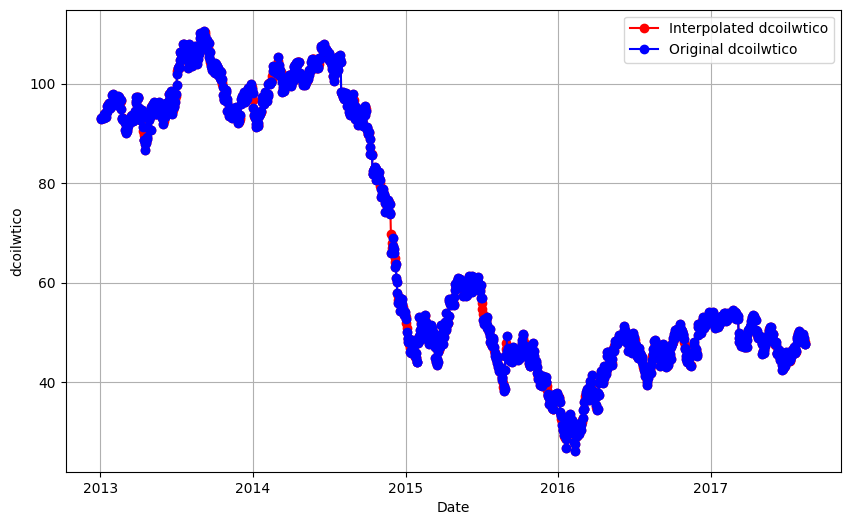

In [ ]:
# Interpolate.
oil_interpolated = oil
# Add the full date range
full_date_range = pd.date_range(start=oil['date'].min(), end=oil['date'].max(), freq='D')
oil_interpolated = oil_interpolated.set_index('date').reindex(full_date_range).reset_index()
oil_interpolated.rename(columns={'index': 'date'}, inplace=True)

oil_interpolated['dcoilwtico_interpolated'] = oil_interpolated['dcoilwtico'].interpolate(method='linear')
oil_interpolated['value_type'] = np.where(oil_interpolated['dcoilwtico'].isnull(), 'Interpolated', 'Original')

#oil_interpolated.head(10)


# Plot
plt.figure(figsize=(10,6))
plt.plot(oil_interpolated['date'], oil_interpolated['dcoilwtico_interpolated'], label='Interpolated dcoilwtico', marker='o', color='red')
plt.plot(oil_interpolated['date'], oil_interpolated['dcoilwtico'], label='Original dcoilwtico', marker='o', color='blue')
plt.xlabel('Date')
plt.ylabel('dcoilwtico')
plt.legend()
plt.grid(True)
plt.show()

### Q5 Again, left join oil on the dataframe above and report the spearman correlation between oil and sales and oil and transactions

In [ ]:
print("Correlation with Daily Oil Prices:")
# Find correlation with sales & transactions

#left join train and test
train = train.merge(oil_interpolated, on='date', how='left')
test = test.merge(oil_interpolated, on='date', how='left')
new_train = new_train.merge(oil_interpolated, on='date', how='left')


spearman_corr_sales = new_train['total_sales'].corr(new_train['dcoilwtico_interpolated'], method = 'spearman')
spearman_corr_transactions = new_train['transactions'].corr(new_train['dcoilwtico_interpolated'], method = 'spearman')

print("Spearman Correlation (Sales vs Oil):")
print(spearman_corr_sales)

print("Spearman Correlation (Transactions vs Oil):")
print(spearman_corr_transactions)



Correlation with Daily Oil Prices:
Spearman Correlation (Sales vs Oil):
-0.3031175844560283
Spearman Correlation (Transactions vs Oil):
0.03992578252883594


### Q6 Report the top-3 highest negative correlations between oil and sales of a particular product family. Now think whether oil should be discarded as a feature?

Use sort_values

In [ ]:
# Calculate all correlations
product_family_train = train
product_family_train.head(10)
product_family_train = product_family_train.groupby(['date','family']).agg(
    sales = ('sales', 'sum'),
    oil = ('dcoilwtico_interpolated', 'sum')
).reset_index()

correlations = product_family_train.groupby('family').apply(
    lambda x: x['sales'].corr(x['oil']), include_groups=False
).reset_index(name='correlation').sort_values('correlation', ascending=True)
# Report the top 3
print(correlations[:3])

                 family  correlation
16  HOME AND KITCHEN II    -0.800638
15   HOME AND KITCHEN I    -0.720620
23            MAGAZINES    -0.685493


<h3>Analysis of Oil</h3>
<p>I believe that keeping oil is correct. Not only is it intuitively a vital part of Ecuador's economy, there is a strong negative correlation with certain sales of product families, correlation tells us that it is not redundant from sales and transactions, and it captures certain context that is not shown in the other columns.</p>

### Q7. Which 2 features do you think fit the description of look-ahead data leakage? [0.1 Points]

In [ ]:
print("The 2 data leakage features are: <feature-1> and <feature-2>")

The 2 data leakage features are: <feature-1> and <feature-2>


### Q8. One hot encode the holidays and events data and similarly left join it to the the main dataframe.

You just have to finish the one-hot encoder function definition for this one.

In [ ]:
def one_hot_encoder(df: pd.DataFrame, nan_as_category: bool = True) -> Tuple[pd.DataFrame, List[str]]:
    # One hot encoding (pandas can do it on 1 line!)
    original_columns = list(df.columns)
    categorical_columns = df.select_dtypes(["category", "object"]).columns.tolist()
    new_df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    # Store the new columns in a list
    new_columns = [col for col in new_df.columns if col not in original_columns]
    # Replace " " with "_" in column names.
    new_columns = [col.replace(' ', '_') for col in new_columns]
    new_df.columns = new_df.columns.str.replace(' ', '_')
    # Return the new dataframe and all the columns (as a list)
    return new_df, new_columns

In [ ]:
#########################
# DO NOT CHANGE.
# NOTE: Run this after you have implemented the one_hot_encoder function above.
#########################

d = pd.merge(train._append(test), stores)
d["store_nbr"] = d["store_nbr"].astype("int8")

# National Holidays & Events
d = pd.merge(d, national, how = "left")
# Regional
d = pd.merge(d, regional, how = "left", on = ["date", "state"])
# Local
d = pd.merge(d, local, how = "left", on = ["date", "city"])

# Work Day: It will be removed when real work day colum created
d = pd.merge(d,  work_day[["date", "type"]].rename({"type":"IsWorkDay"}, axis = 1),how = "left")

events, events_cat = one_hot_encoder(events, nan_as_category=False)
events["events_Dia_de_la_Madre"] = np.where(events.date == "2016-05-08", 1, events["events_Dia_de_la_Madre"])
events = events.drop(239)

d = pd.merge(d, events, how = "left")
d[events_cat] = d[events_cat].fillna(0)

# New features
d["holiday_national_binary"] = np.where(d.holiday_national.notnull(), 1, 0)
d["holiday_local_binary"] = np.where(d.holiday_local.notnull(), 1, 0)
d["holiday_regional_binary"] = np.where(d.holiday_regional.notnull(), 1, 0)
d["national_independence"] = np.where(d.holiday_national.isin(['Batalla de Pichincha',  'Independencia de Cuenca', 'Independencia de Guayaquil', 'Independencia de Guayaquil', 'Primer Grito de Independencia']), 1, 0)
d["local_cantonizacio"] = np.where(d.holiday_local.str.contains("Cantonizacio"), 1, 0)
d["local_fundacion"] = np.where(d.holiday_local.str.contains("Fundacion"), 1, 0)
d["local_independencia"] = np.where(d.holiday_local.str.contains("Independencia"), 1, 0)


holidays, holidays_cat = one_hot_encoder(d[["holiday_national","holiday_regional","holiday_local"]], nan_as_category=False)
d = pd.concat([d.drop(["holiday_national","holiday_regional","holiday_local"], axis = 1),holidays], axis = 1)

he_cols = d.columns[d.columns.str.startswith("events")].tolist() + d.columns[d.columns.str.startswith("holiday")].tolist() + d.columns[d.columns.str.startswith("national")].tolist()+ d.columns[d.columns.str.startswith("local")].tolist()
d[he_cols] = d[he_cols].astype("int8")

d[["family", "city", "state", "type"]] = d[["family", "city", "state", "type"]].astype("category")

del holidays, holidays_cat, work_day, local, regional, national, events, events_cat, tr, tr1, tr2, he_cols
gc.collect()

6040

In [ ]:
d.tail(10)

id       date  store_nbr                      family  sales  \
3002924  3000878 2017-08-15          9                   MAGAZINES    NaN   
3002925  3000879 2017-08-15          9                       MEATS    NaN   
3002926  3000880 2017-08-15          9               PERSONAL CARE    NaN   
3002927  3000881 2017-08-15          9                PET SUPPLIES    NaN   
3002928  3000882 2017-08-15          9     PLAYERS AND ELECTRONICS    NaN   
3002929  3000883 2017-08-15          9                     POULTRY    NaN   
3002930  3000884 2017-08-15          9              PREPARED FOODS    NaN   
3002931  3000885 2017-08-15          9                     PRODUCE    NaN   
3002932  3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES    NaN   
3002933  3000887 2017-08-15          9                     SEAFOOD    NaN   

         onpromotion  dcoilwtico  dcoilwtico_interpolated value_type   city  \
3002924          0.0       47.57                    47.57   Original  Quito   
3002925          0.0       47.57                    47.57   Original  Quito   
3002926         11.0       47.57                    47.57   Original  Quito   
3002927          0.0       47.57                    47.57   Original  Quito   
3002928          0.0       47.57                    47.57   Original  Quito   
3002929          0.0       47.57                    47.57   Original  Quito   
3002930          1.0       47.57                    47.57   Original  Quito   
3002931        148.0       47.57                    47.57   Original  Quito   
3002932          8.0       47.57                    47.57   Original  Quito   
3002933          0.0       47.57                    47.57   Original  Quito   

             state type  cluster IsWorkDay  events_Black_Friday  \
3002924  Pichincha    B        6       NaN                    0   
3002925  Pichincha    B        6       NaN                    0   
3002926  Pichincha    B        6       NaN                    0   
3002927  Pichincha    B        6       NaN                    0   
3002928  Pichincha    B        6       NaN                    0   
3002929  Pichincha    B        6       NaN                    0   
3002930  Pichincha    B        6       NaN                    0   
3002931  Pichincha    B        6       NaN                    0   
3002932  Pichincha    B        6       NaN                    0   
3002933  Pichincha    B        6       NaN                    0   

         events_Cyber_Monday  events_Dia_de_la_Madre  events_Futbol  \
3002924                    0                       0              0   
3002925                    0                       0              0   
3002926                    0                       0              0   
3002927                    0                       0              0   
3002928                    0                       0              0   
3002929                    0                       0              0   
3002930                    0                       0              0   
3002931                    0                       0              0   
3002932                    0                       0              0   
3002933                    0                       0              0   

         events_Terremoto_Manabi  events_Terremoto_Manabi1  \
3002924                        0                         0   
3002925                        0                         0   
3002926                        0                         0   
3002927                        0                         0   
3002928                        0                         0   
3002929                        0                         0   
3002930                        0                         0   
3002931                        0                         0   
3002932                        0                         0   
3002933                        0                         0   

         events_Terremoto_Manabi10  events_Terremoto_Manabi11  \
3002924                     

In [ ]:
#########################
# DO NOT CHANGE
#########################
train = d[d.date < "2017-08-01"]
test = d[d.date >= "2017-08-01"]
test = test.drop(["sales"], axis=1)

train = pd.get_dummies(train, columns=train.select_dtypes(['object']).columns)
train = pd.get_dummies(train, columns=train.select_dtypes(['category']).columns)
for col in train.columns:
    if pd.api.types.is_numeric_dtype(train[col]):
        train[col] = train[col].astype('float32')

test = pd.get_dummies(test, columns=test.select_dtypes(['object']).columns)
test = pd.get_dummies(test, columns=test.select_dtypes(['category']).columns)
for col in test.columns:
    if pd.api.types.is_numeric_dtype(test[col]):
        test[col] = test[col].astype('float32')

In [ ]:
replace_dict = {}
for x in train.columns:
    if "family" in x:
        if " " in x:
            lst = x.split(" ")
            new_feature_name = ""
            for k in lst:
                new_feature_name += str(k)
                new_feature_name += "_"
            replace_dict[x] = new_feature_name[:-1]
        if "," in x:
            lst = x.split(",")
            new_feature_name = ""
            for k in lst:
                new_feature_name += str(k)
                new_feature_name += "_"
            replace_dict[x] = new_feature_name[:-1]
        if "/" in x:
            lst = x.split(",")
            new_feature_name = ""
            for k in lst:
                new_feature_name += str(k)
                new_feature_name += "_"
            replace_dict[x] = new_feature_name[:-1]

    elif "state" in x:
        lst = x.split(",")
        new_feature_name = ""
        for k in lst:
            new_feature_name += str(k)
            new_feature_name += "_"
        replace_dict[x] = new_feature_name[:-1]

replace_dict

{'family_BABY CARE': 'family_BABY_CARE',
 'family_BREAD/BAKERY': 'family_BREAD/BAKERY',
 'family_FROZEN FOODS': 'family_FROZEN_FOODS',
 'family_GROCERY I': 'family_GROCERY_I',
 'family_GROCERY II': 'family_GROCERY_II',
 'family_HOME AND KITCHEN I': 'family_HOME_AND_KITCHEN_I',
 'family_HOME AND KITCHEN II': 'family_HOME_AND_KITCHEN_II',
 'family_HOME APPLIANCES': 'family_HOME_APPLIANCES',
 'family_HOME CARE': 'family_HOME_CARE',
 'family_LAWN AND GARDEN': 'family_LAWN_AND_GARDEN',
 'family_LIQUOR,WINE,BEER': 'family_LIQUOR_WINE_BEER',
 'family_PERSONAL CARE': 'family_PERSONAL_CARE',
 'family_PET SUPPLIES': 'family_PET_SUPPLIES',
 'family_PLAYERS AND ELECTRONICS': 'family_PLAYERS_AND_ELECTRONICS',
 'family_PREPARED FOODS': 'family_PREPARED_FOODS',
 'family_SCHOOL AND OFFICE SUPPLIES': 'family_SCHOOL_AND_OFFICE_SUPPLIES',
 'state_Azuay': 'state_Azuay',
 'state_Bolivar': 'state_Bolivar',
 'state_Chimborazo': 'state_Chimborazo',
 'state_Cotopaxi': 'state_Cotopaxi',
 'state_El Oro': 'state_

In [ ]:
train.rename(columns=replace_dict)
test.rename(columns=replace_dict)

id       date  store_nbr  onpromotion  dcoilwtico  \
2976204  2974158.0 2017-08-01        1.0          0.0   49.189999   
2976205  2974159.0 2017-08-01        1.0          0.0   49.189999   
2976206  2974160.0 2017-08-01        1.0          0.0   49.189999   
2976207  2974161.0 2017-08-01        1.0         26.0   49.189999   
2976208  2974162.0 2017-08-01        1.0          0.0   49.189999   
...            ...        ...        ...          ...         ...   
3002929  3000883.0 2017-08-15        9.0          0.0   47.570000   
3002930  3000884.0 2017-08-15        9.0          1.0   47.570000   
3002931  3000885.0 2017-08-15        9.0        148.0   47.570000   
3002932  3000886.0 2017-08-15        9.0          8.0   47.570000   
3002933  3000887.0 2017-08-15        9.0          0.0   47.570000   

         dcoilwtico_interpolated  cluster  events_Black_Friday  \
2976204                49.189999     13.0                  0.0   
2976205                49.189999     13.0                  0.0   
2976206                49.189999     13.0                  0.0   
2976207                49.189999     13.0                  0.0   
2976208                49.189999     13.0                  0.0   
...                          ...      ...                  ...   
3002929                47.570000      6.0                  0.0   
3002930                47.570000      6.0                  0.0   
3002931                47.570000      6.0                  0.0   
3002932                47.570000      6.0                  0.0   
3002933                47.570000      6.0                  0.0   

         events_Cyber_Monday  events_Dia_de_la_Madre  events_Futbol  \
2976204                  0.0                     0.0            0.0   
2976205                  0.0                     0.0            0.0   
2976206                  0.0                     0.0            0.0   
2976207                  0.0                     0.0            0.0   
2976208                  0.0                     0.0            0.0   
...                      ...                     ...            ...   
3002929                  0.0                     0.0            0.0   
3002930                  0.0                     0.0            0.0   
3002931                  0.0                     0.0            0.0   
3002932                  0.0                     0.0            0.0   
3002933                  0.0                     0.0            0.0   

         events_Terremoto_Manabi  events_Terremoto_Manabi1  \
2976204                      0.0                       0.0   
2976205                      0.0                       0.0   
2976206                      0.0                       0.0   
2976207                      0.0                       0.0   
2976208                      0.0                       0.0   
...                          ...                       ...   
3002929                      0.0                       0.0   
3002930                      0.0                       0.0   
3002931                      0.0                       0.0   
3002932                      0.0                       0.0   
3002933                      0.0                       0.0   

         events_Terremoto_Manabi10  events_Terremoto_Manabi11  \
2976204                        0.0                        0.0   
2976205                        0.0                        0.0   
2976206                        0.0                        0.0   
2976207                        0.0                        0.0   
2976208                        0.0                        0.0   
...                            ...                        ...   
3002929                        0.0                        0.0   
3002930                        0.0                        0.0   
3002931                        0.0                        0.0   
3002932                        0.0                        0.0   
3002933                        0.0                        0.0   

         events

In [ ]:
import re
train = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test = test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

## Section 2

### Q9. EMA

Forecast window should be >=15 days since the test set is 15 days. **For this question use 16 as the forecast window**

In [ ]:
# Train EMAs for each family per store (pandas has an inbuilt ema function!)
family_columns = [col for col in train.columns if col.startswith('family_')]
stores = train['store_nbr'].unique()

# Train the EMA
results = pd.DataFrame(columns=["date", "store_nbr", "family", "ema"])
results_list = []

# Combine test and train set
new_test = test.copy()
new_test['sales'] = np.nan
combined = pd.concat([train, new_test], axis=0).sort_values('date')

for store in stores:
    #first filter the store_nbr
    store_data = combined[combined['store_nbr'] == store].copy()
    for family_col in family_columns:
        #second filter for family_col
        family_store_data = store_data[store_data[family_col] == 1]

        #apply ema
        ema_value = family_store_data['sales'].ewm(span=16, adjust=False).mean()

        family_store_results = pd.DataFrame({
            'date': family_store_data['date'],
            'store_nbr': store,
            'family': family_col,
            'ema': ema_value
        })

        results_list.append(family_store_results)

# concatenate all the results into a single DataFrame
results = pd.concat(results_list, ignore_index=True)

/tmp/ipykernel_66/1206945080.py:12: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [ ]:
# Make the predictions
# Predict using the last ema value (using join)
pred = test.copy()
family_cols = [col for col in pred.columns if col.startswith('family_')]
pred['family'] = pred[family_cols].idxmax(axis=1)
pred = pd.merge(pred, results, on=['date', 'store_nbr', 'family'], how='left')
pred['sales'] = pred['ema'].fillna(0.0)
pred = pred.drop(columns=['ema'])
pred = pred.drop(columns=['family'])

#pred.head(5)
# Use the make_submission utility function provided to save a submission CSV.
ema_pred = pred['sales']
make_submission(pred['sales'])
# Submit to competition and note your RMSLE score somewhere for this model type.
# RMSLE Score : 0.50611 (Version 8)
# NOTE - 1: You still need to go on the right panel and click submit
# (make_submission will NOT submit to competition -> It just makes a submission ready file)
# NOTE - 2: Ensure that you are not overwriting your submission.csv file in subsequent cells.

### Q10. Linear Regressor

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
# 1. Create a dictionary to store all the models (1 model per family per store)
models = {}
# 2. Fit these models
# Create the same 1782 models as in EMA
family_columns = [col for col in train.columns if col.startswith('family_')]
stores = train['store_nbr'].unique()


for store in stores:
    #first filter the store_nbr (use train)
    store_data = train[train['store_nbr'] == store].copy()
    for family_col in family_columns:
        #second filter for family_col
        family_store_data = store_data[store_data[family_col] == 1]

        #Linear Regression
        y = family_store_data['sales']
        #print(y.dropna())
        #Drop columns + non-interpolated oil
        X = family_store_data.drop(columns=['id', 'date', 'store_nbr', 'sales', 'IsWorkDay_WorkDay', 'dcoilwtico'] + family_columns)
        #Drop nan for X and y (should only lose very few data)
        #Drop first row because I don't trust the 0 sales and because no oil data
        #print(y.index)
        y = y.dropna()
        X = X.loc[y.index]
        X = X.iloc[1:]
        y = y.iloc[1:]

        model = LinearRegression()
        model.fit(X,y)

        models[(store, family_col)] = model

In [ ]:
# 1. Look through each test record and find the corresponding model in models

# We will do the inverse because it should be faster, looking through models
# and finding relevant test records (because of vectorization)
family_columns = [col for col in train.columns if col.startswith('family_')]

pred = test.copy()
#reset index fixes an indexing issue with test.copy()
pred.reset_index(drop=True, inplace=True)
pred['sales'] = 0.0
pred['family'] = pred[family_cols].idxmax(axis=1)
pred_X = pred.drop(columns=['id', 'date', 'store_nbr', 'sales', 'family', 'dcoilwtico'] + family_columns)
for (store, family_col), model in models.items():
    mask = (pred['store_nbr'] == store) & (pred['family'] == family_col)
    if mask.any():
        pred_X_mask = pred_X.loc[mask]
        # 2. Make the predictions on the test set.
        pred.loc[mask, 'sales'] = model.predict(pred_X_mask)
#print(pred['sales'])
# 3. Make the submission using the utility function `make_submission` provided
linear_pred = pred['sales']
make_submission(pred['sales'])
# 4. Submit to competition and note your RMSLE score somewhere for this model type.
#RMSLE: 0.50532 (Version 14)

### Q11. PACF and ACF

Use lib sm

(statsmodel.api is already imported as sm)

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

/tmp/ipykernel_66/3878201066.py:16: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



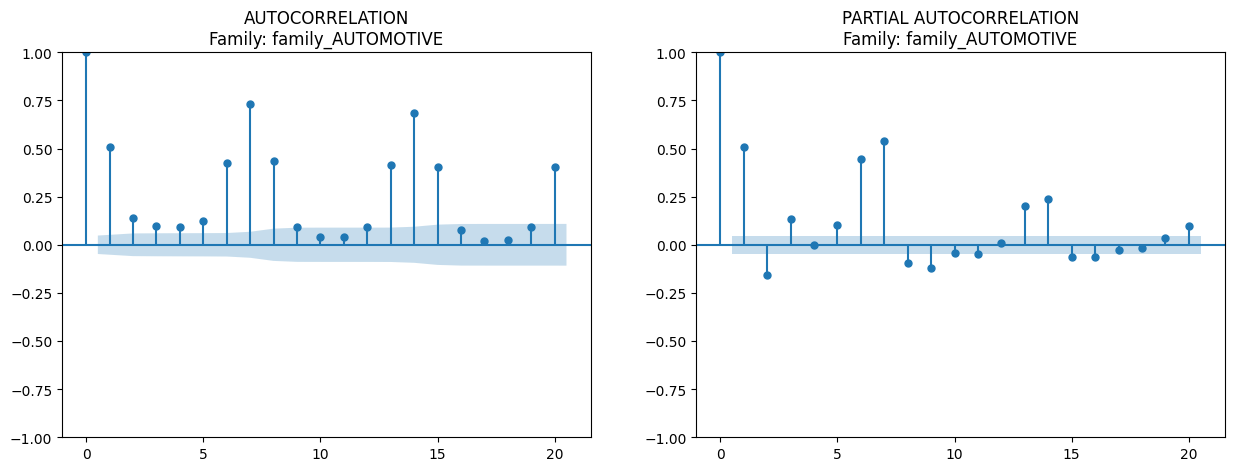

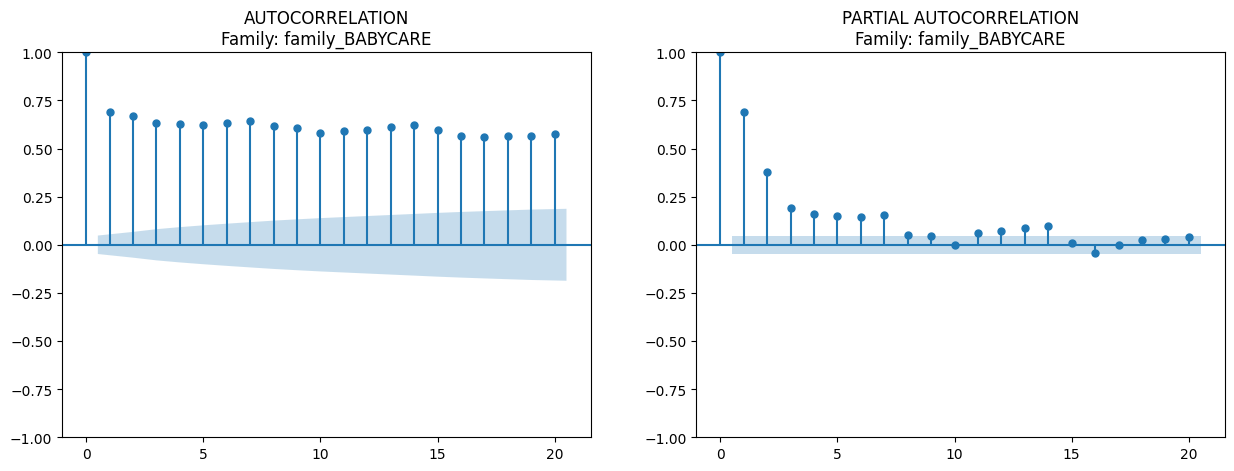

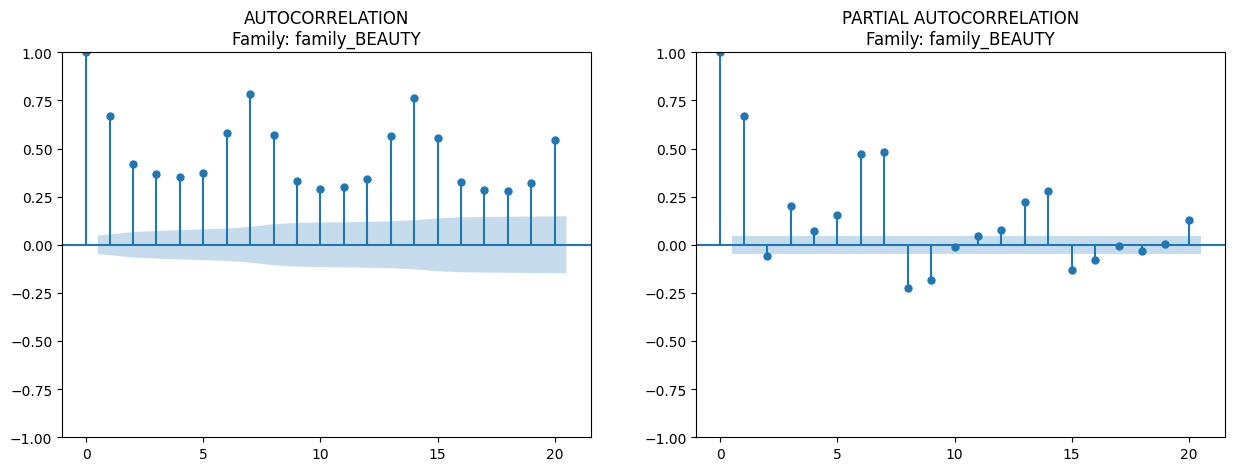

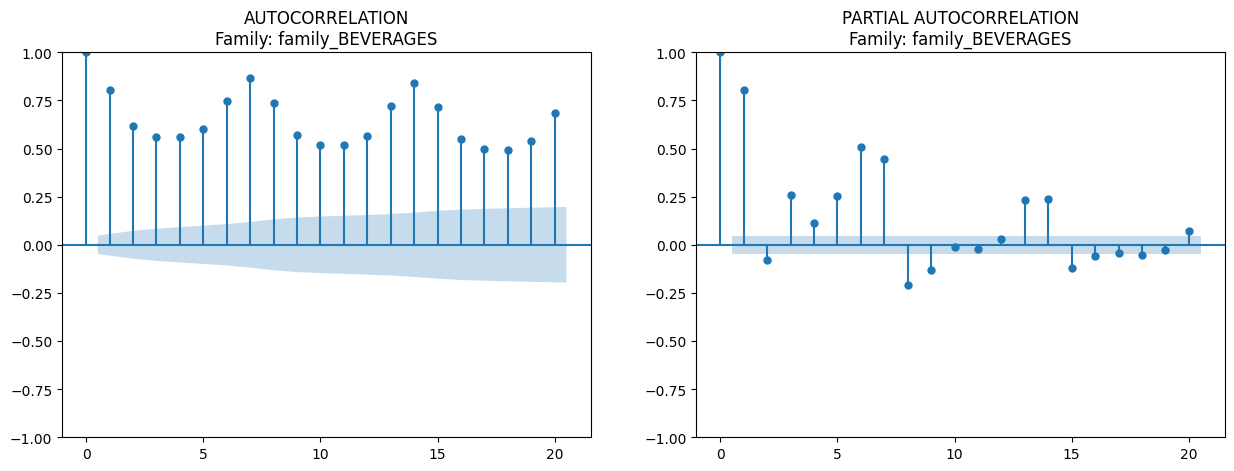

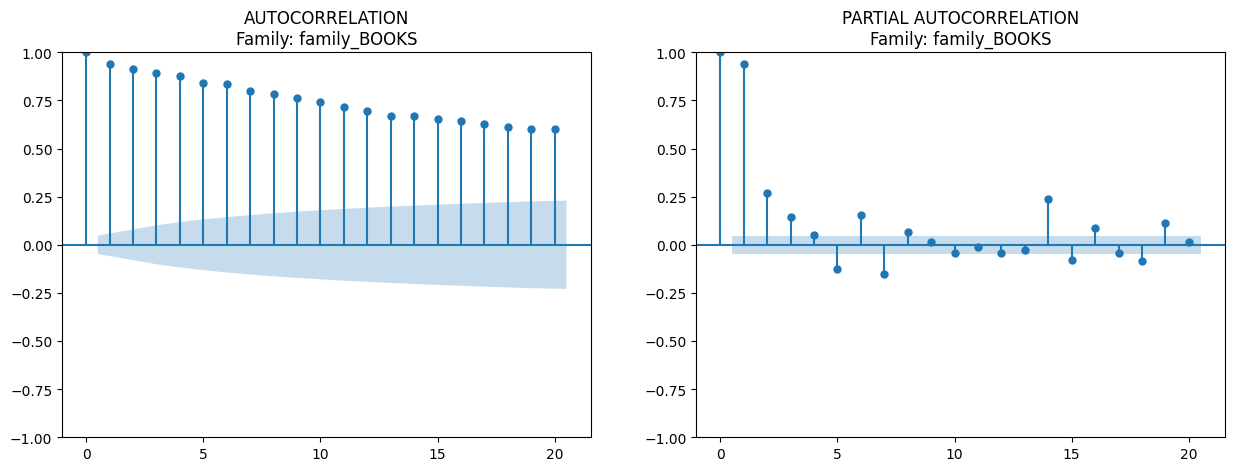

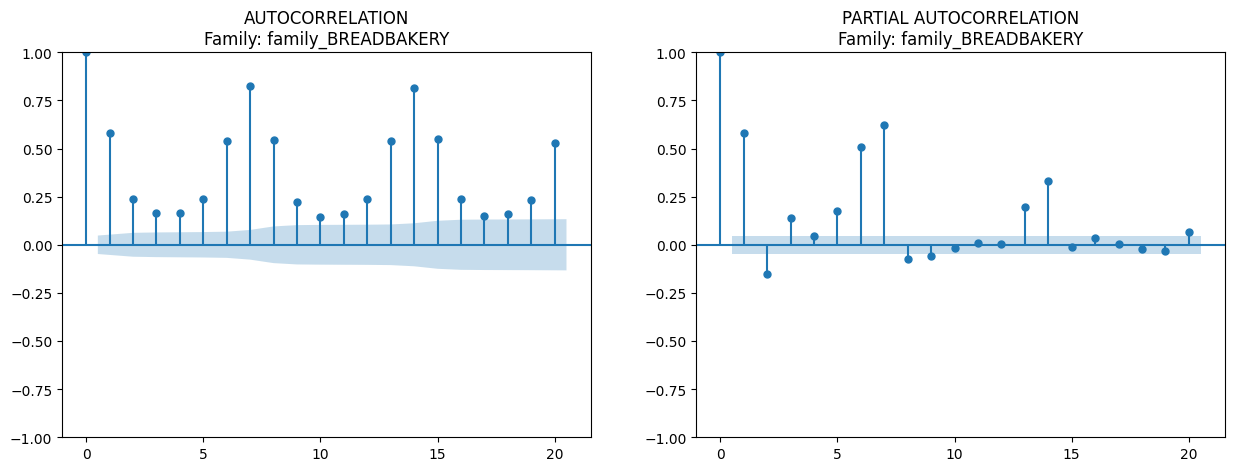

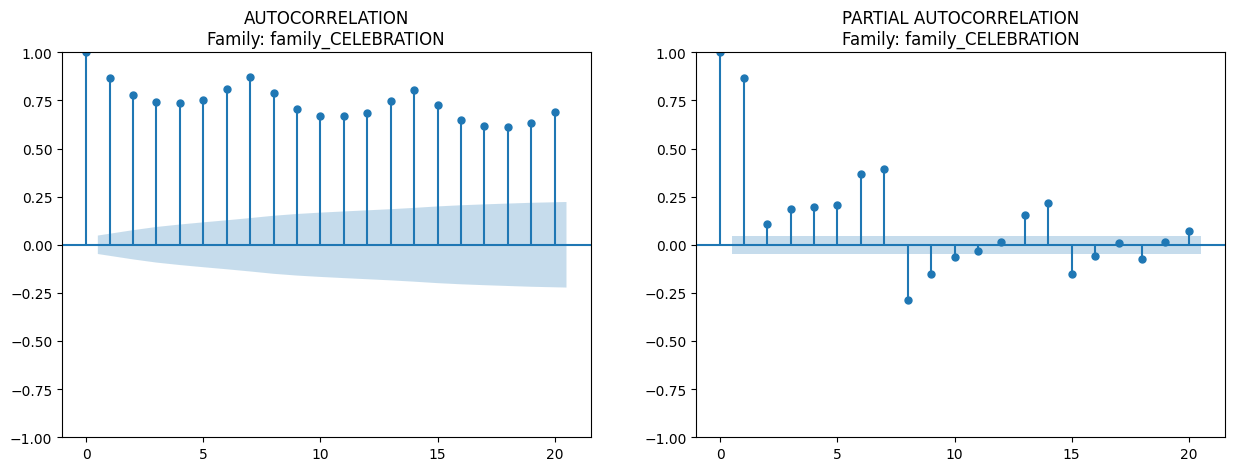

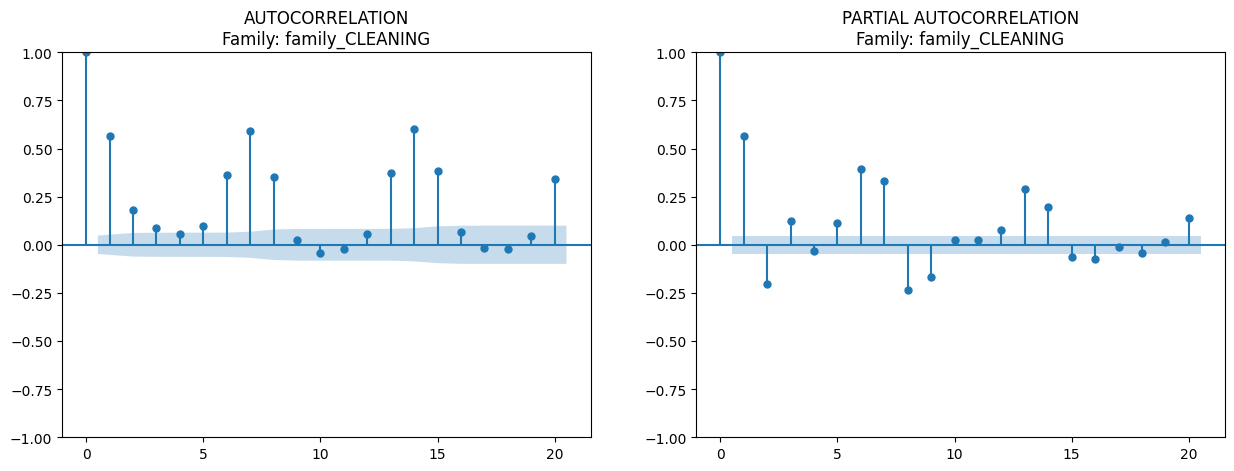

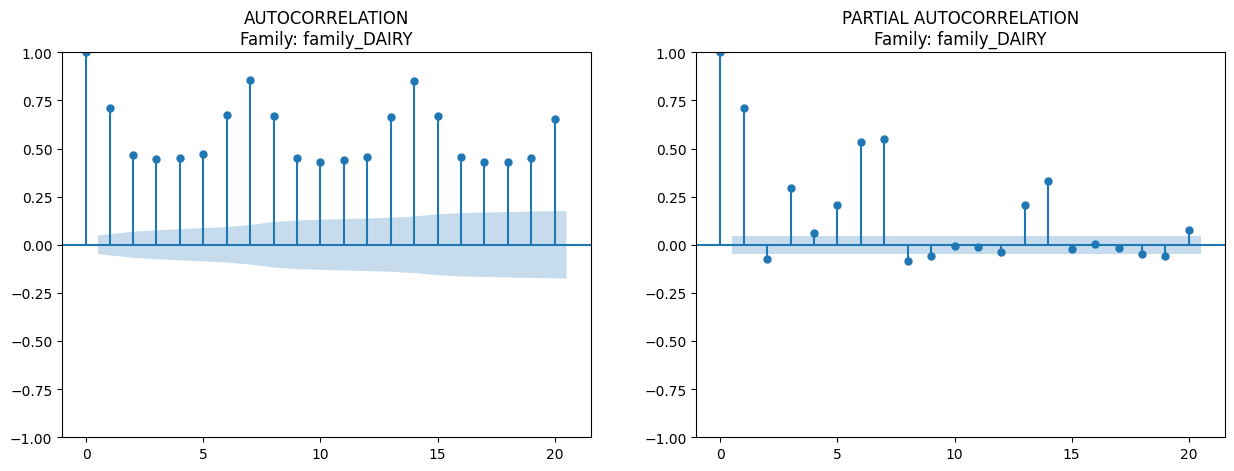

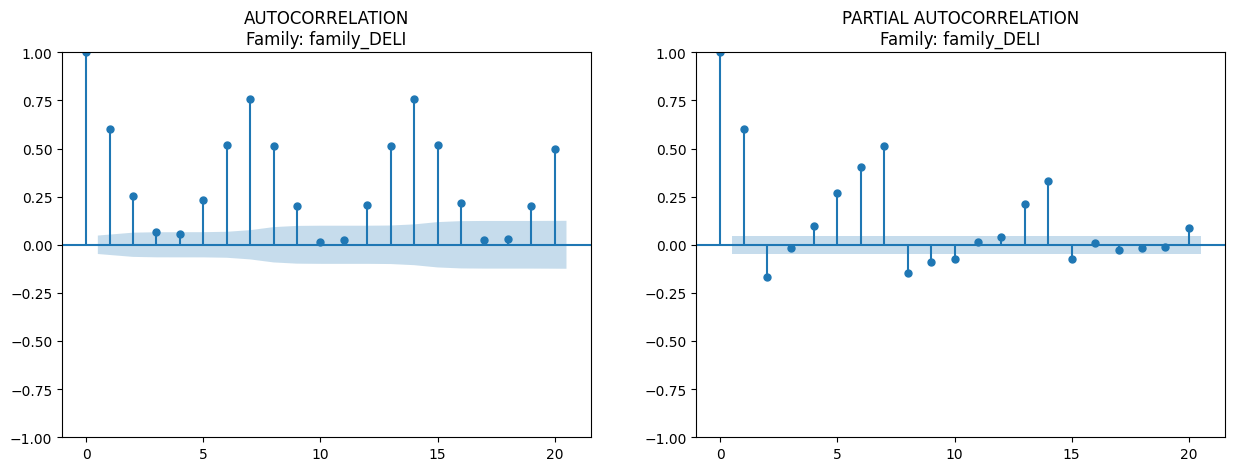

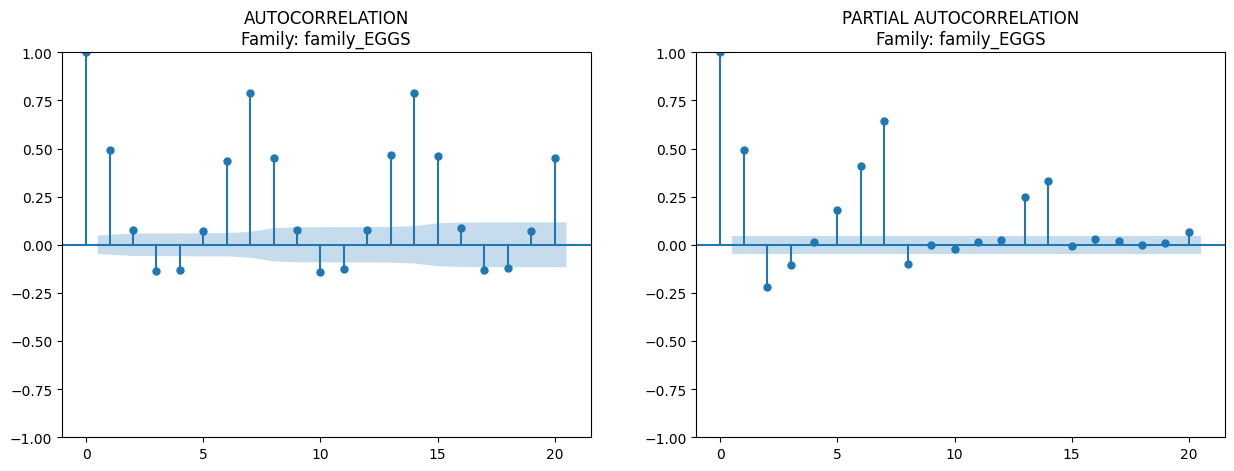

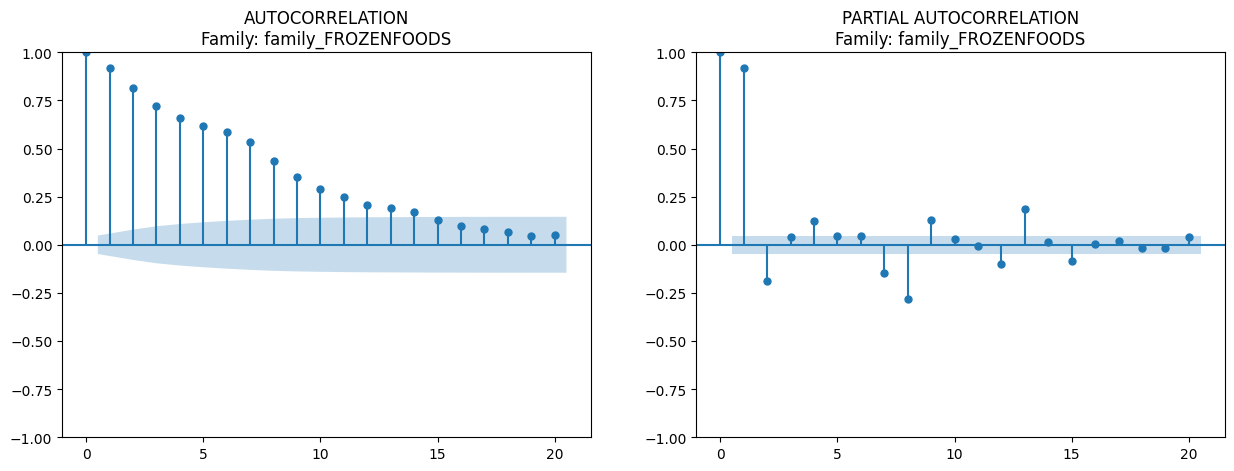

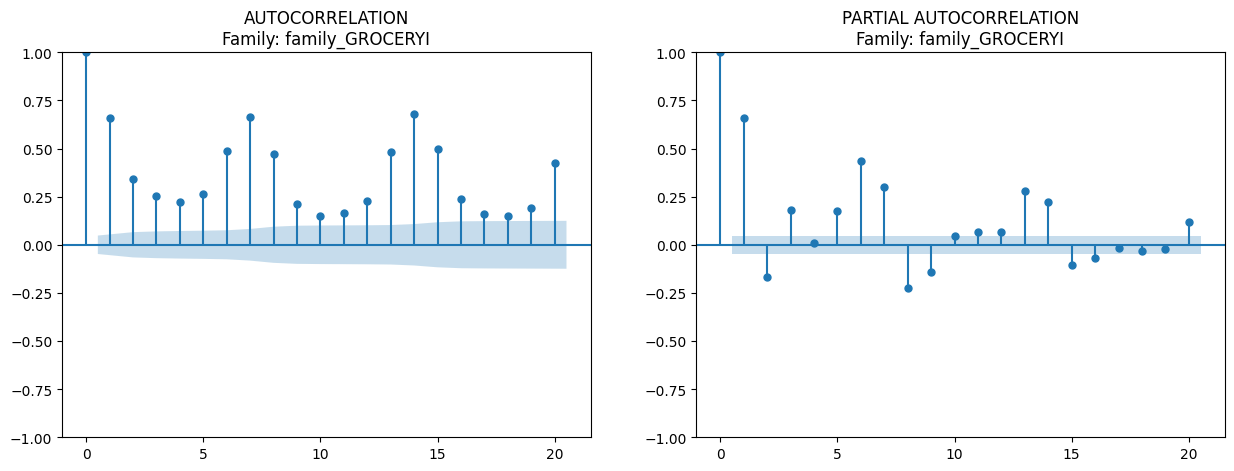

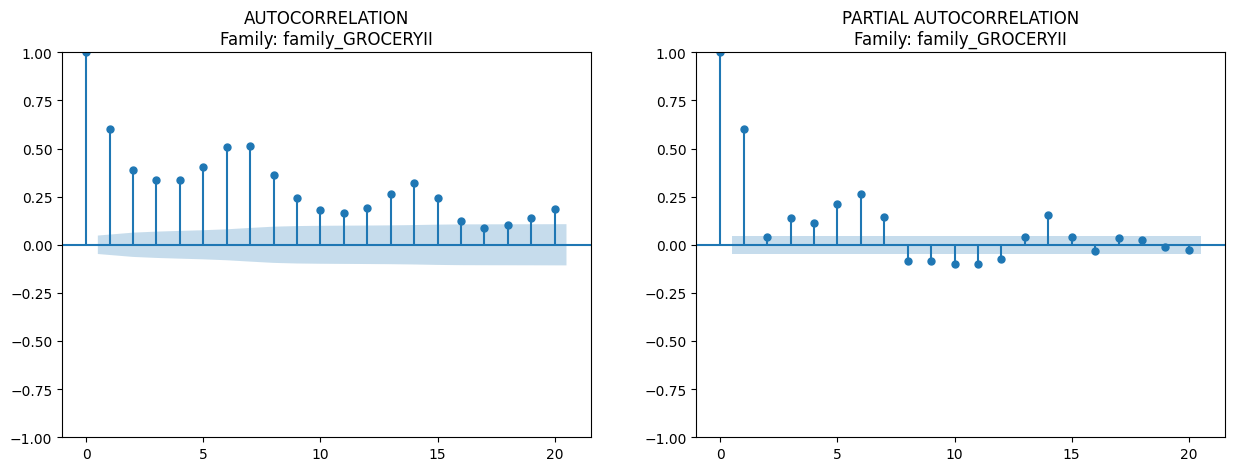

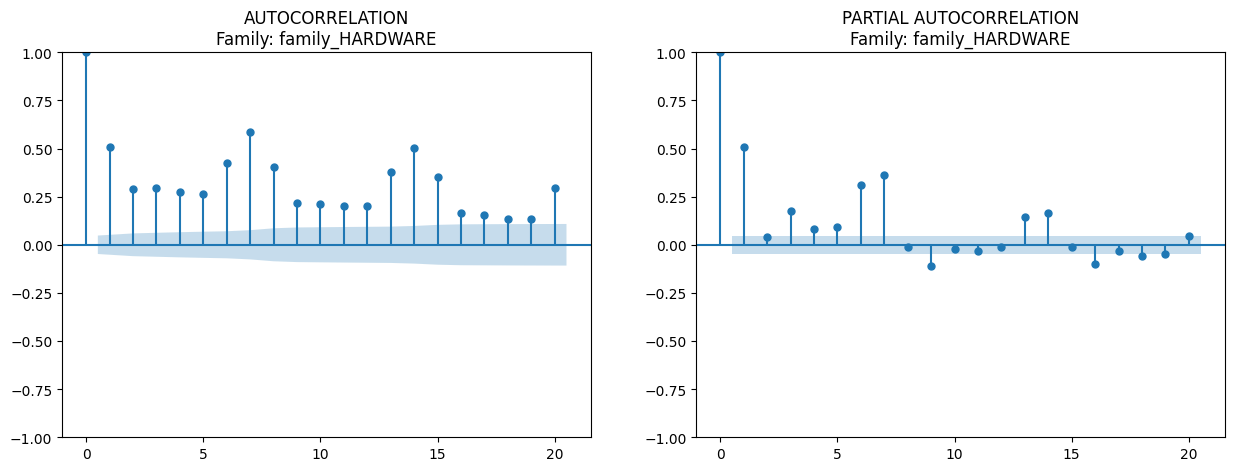

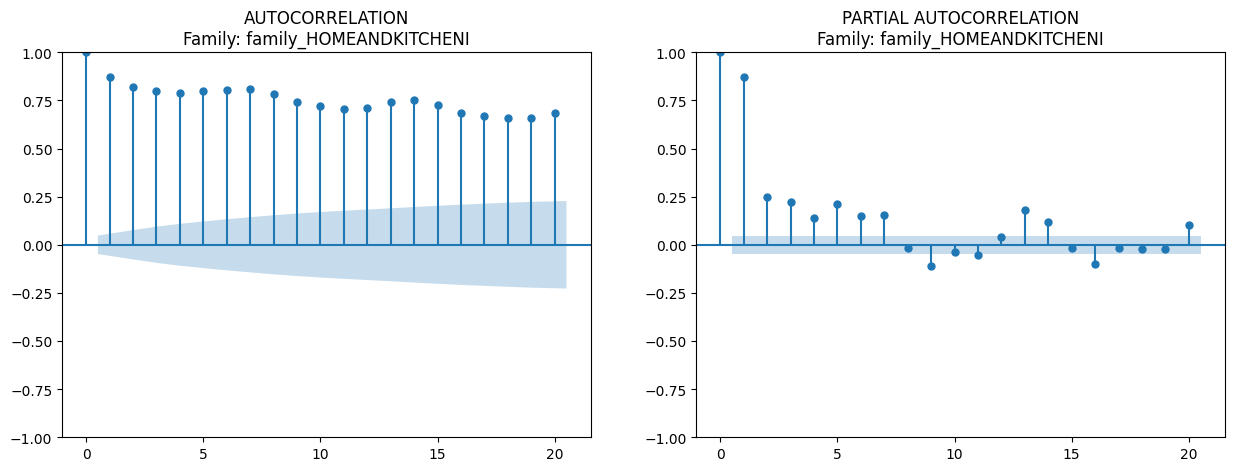

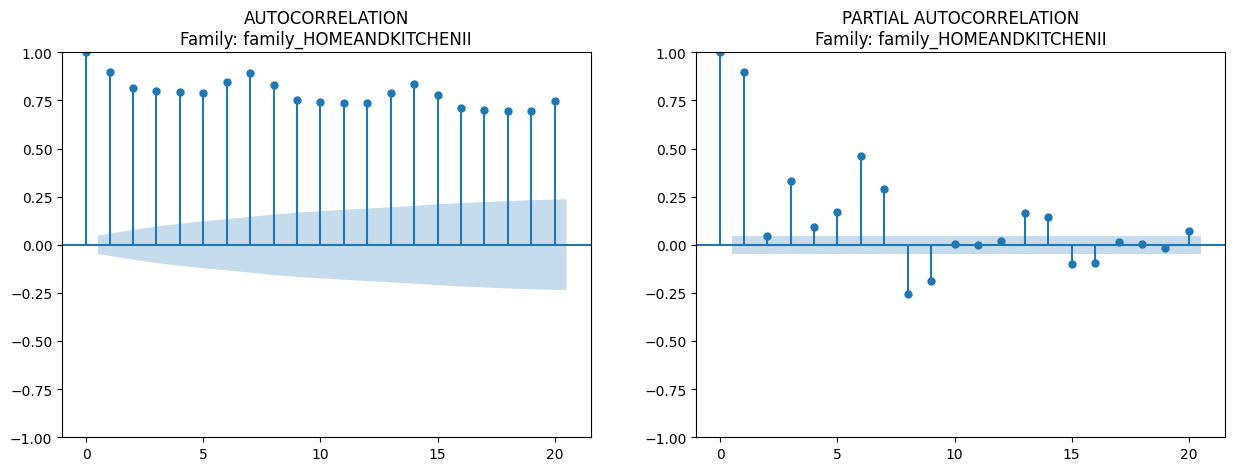

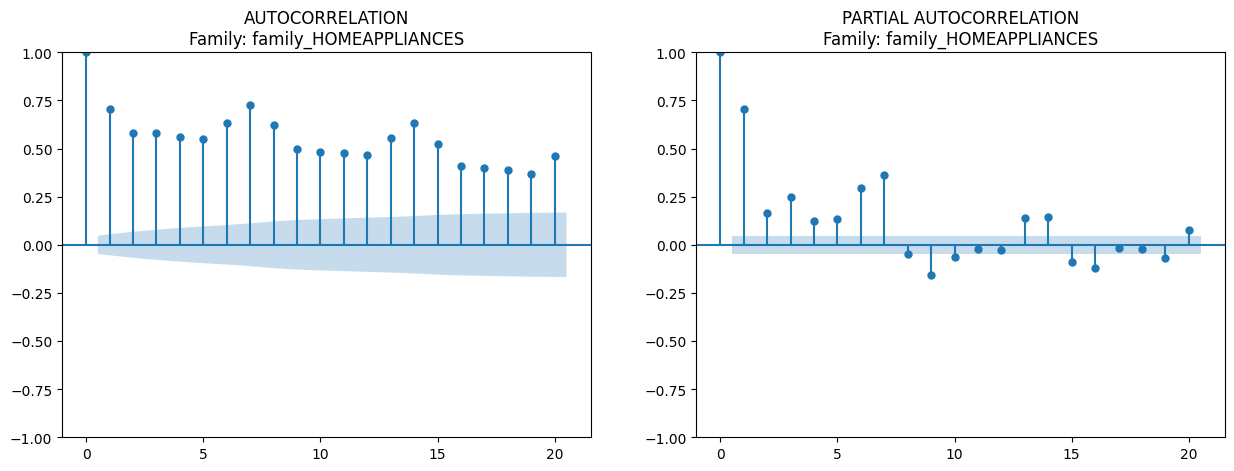

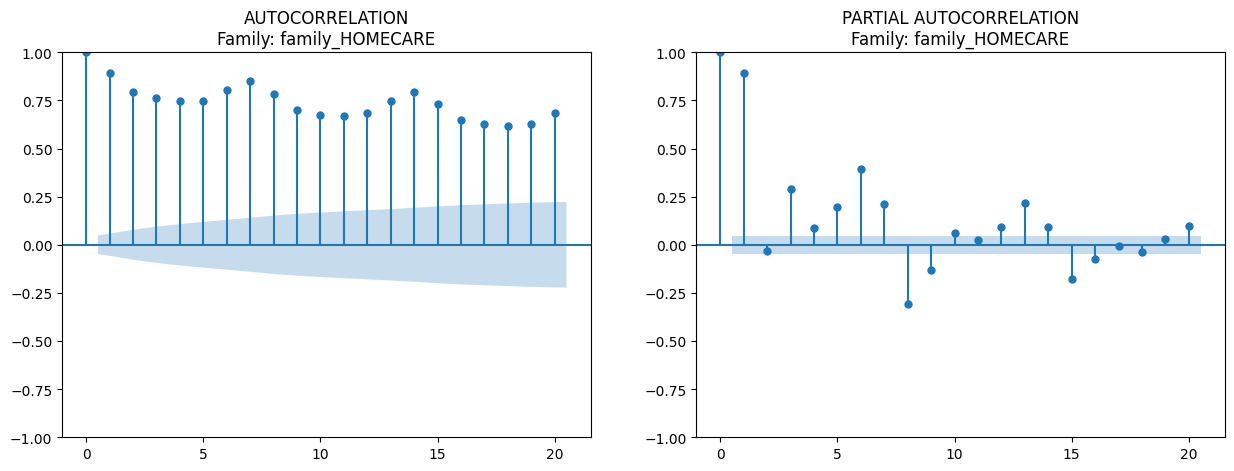

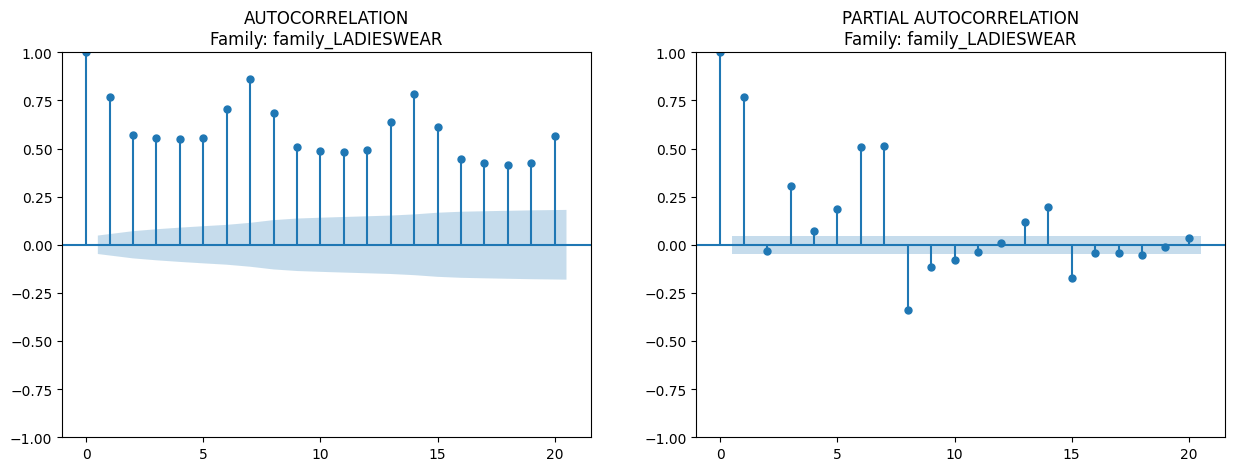

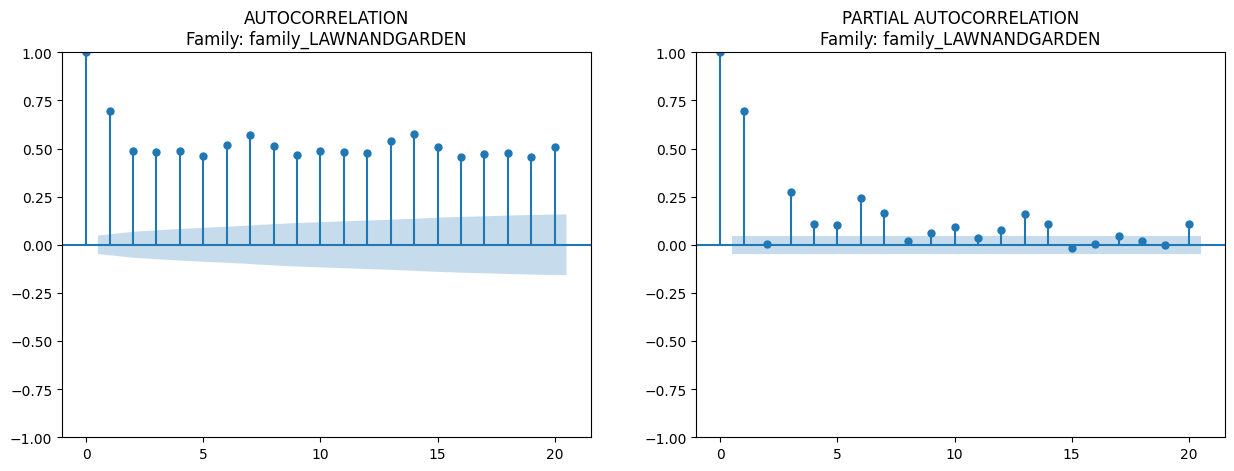

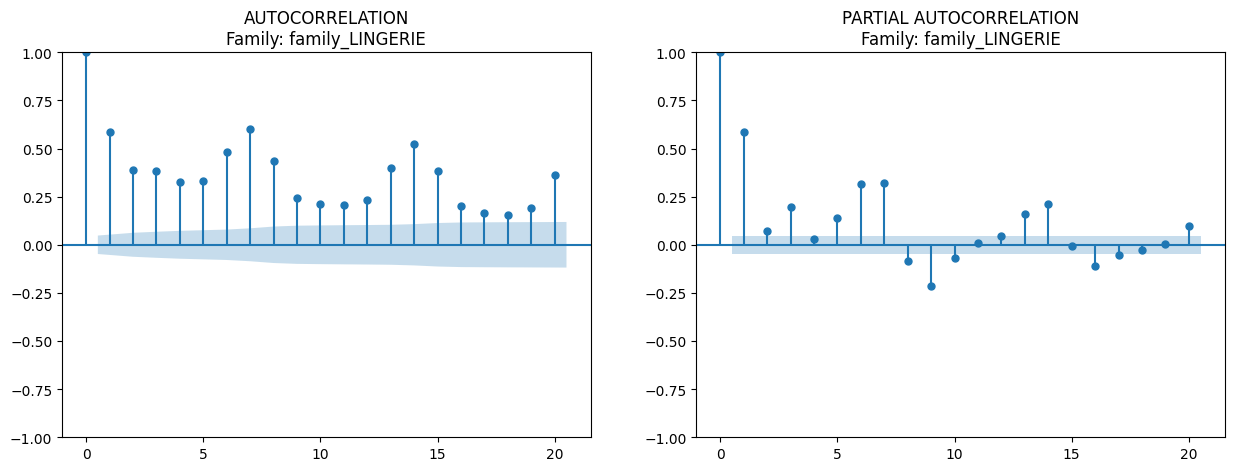

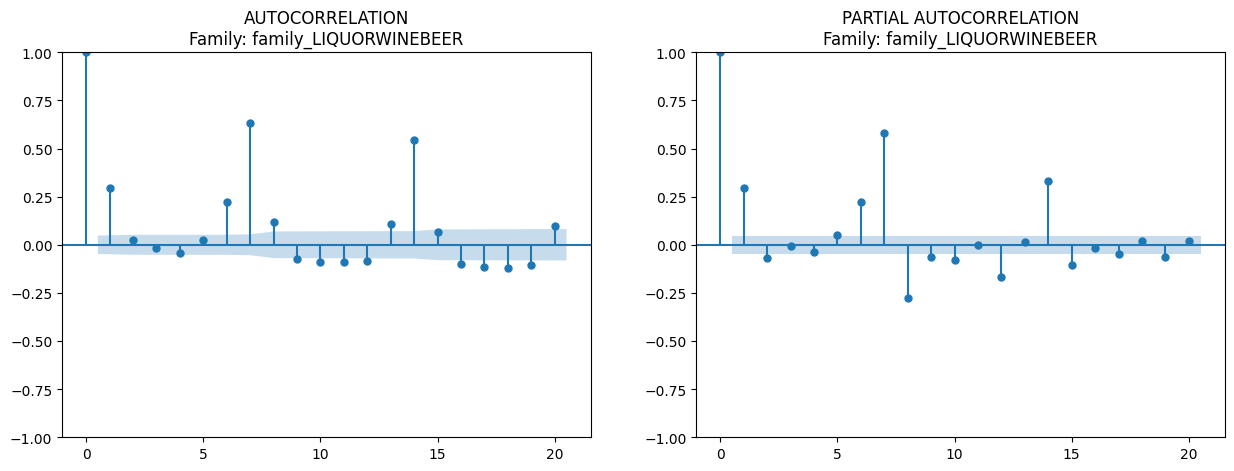

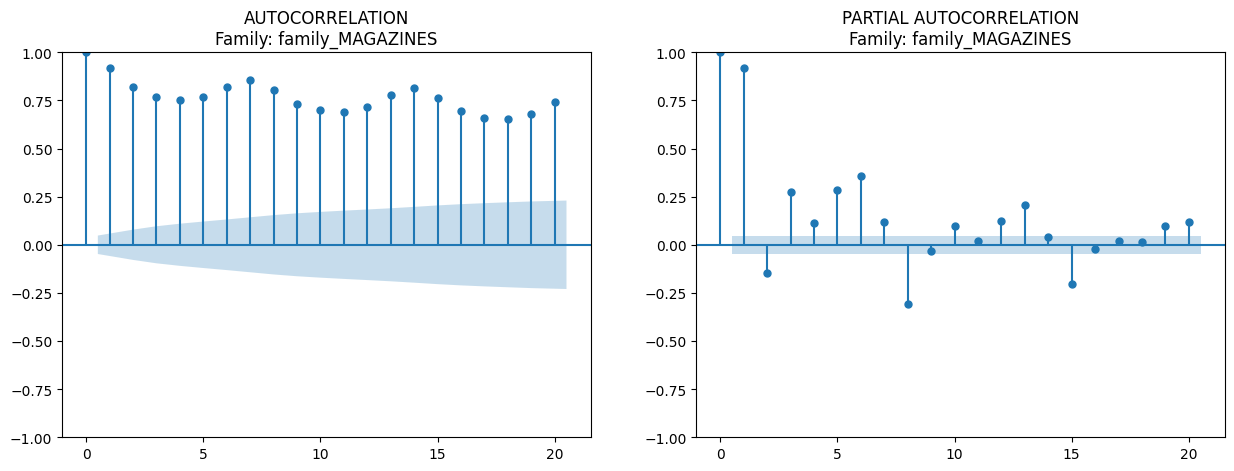

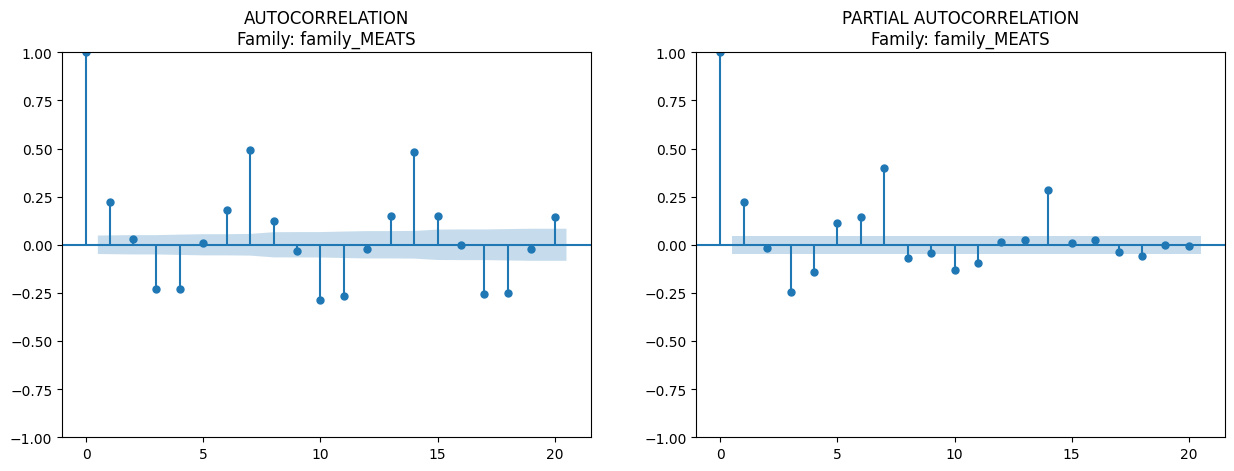

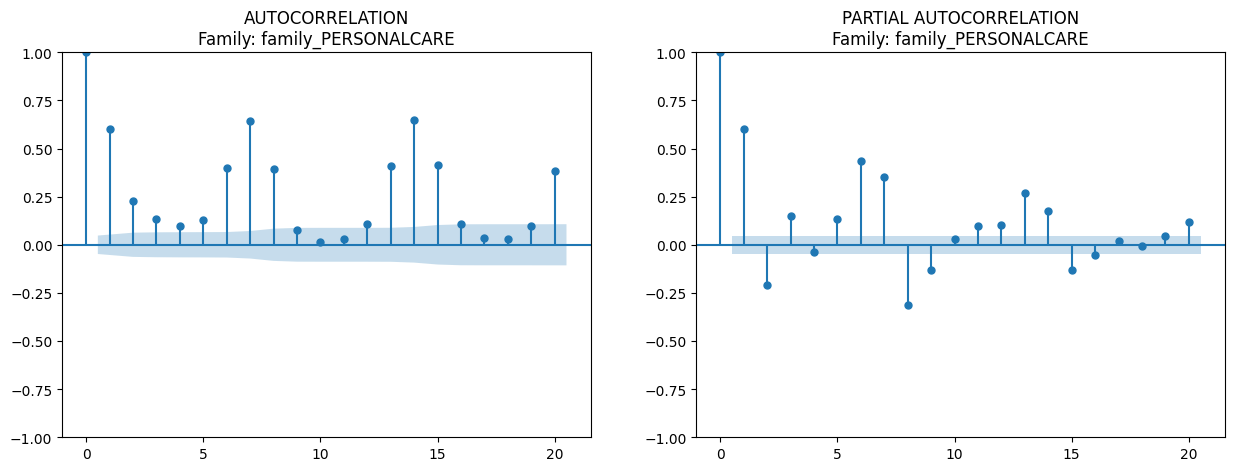

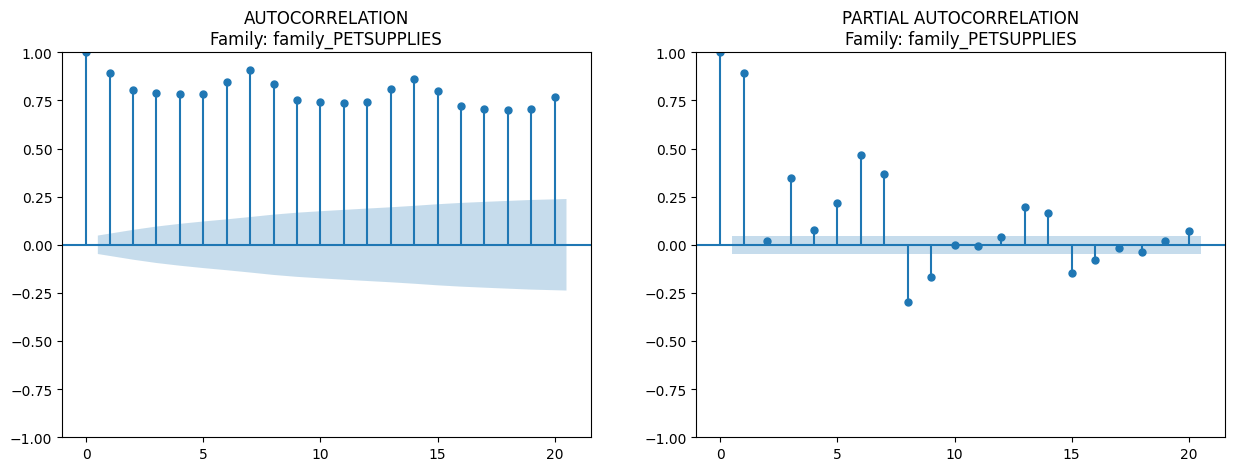

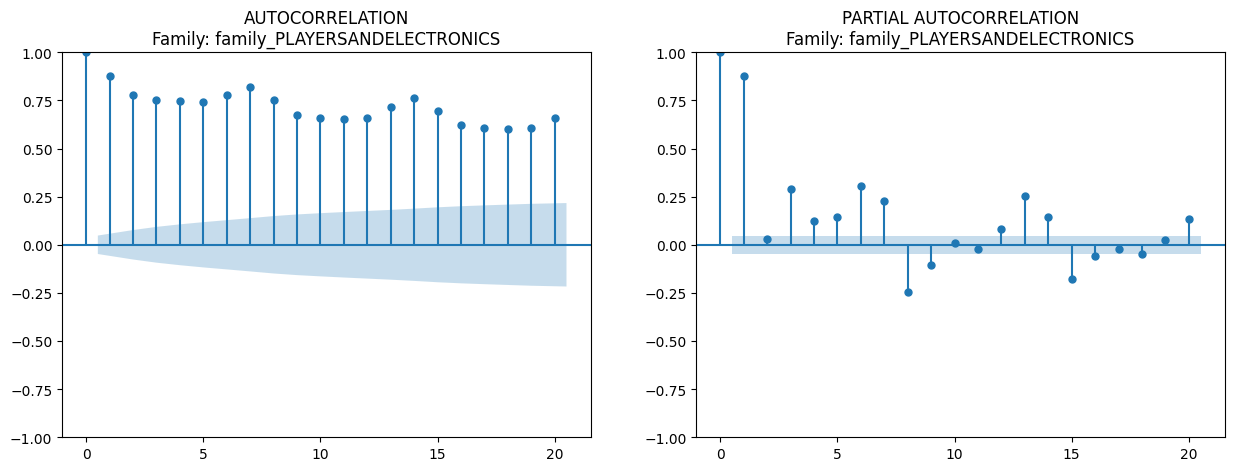

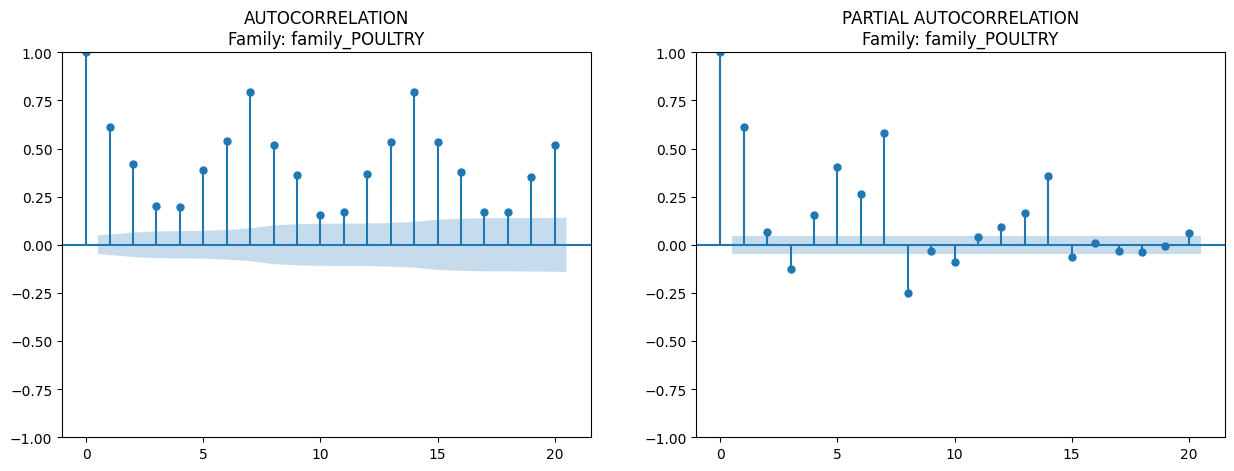

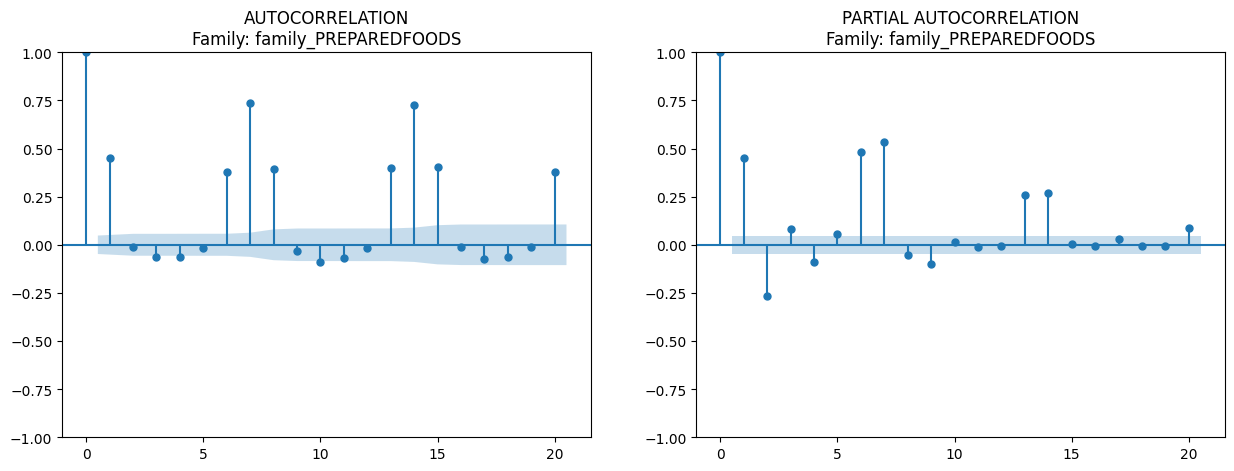

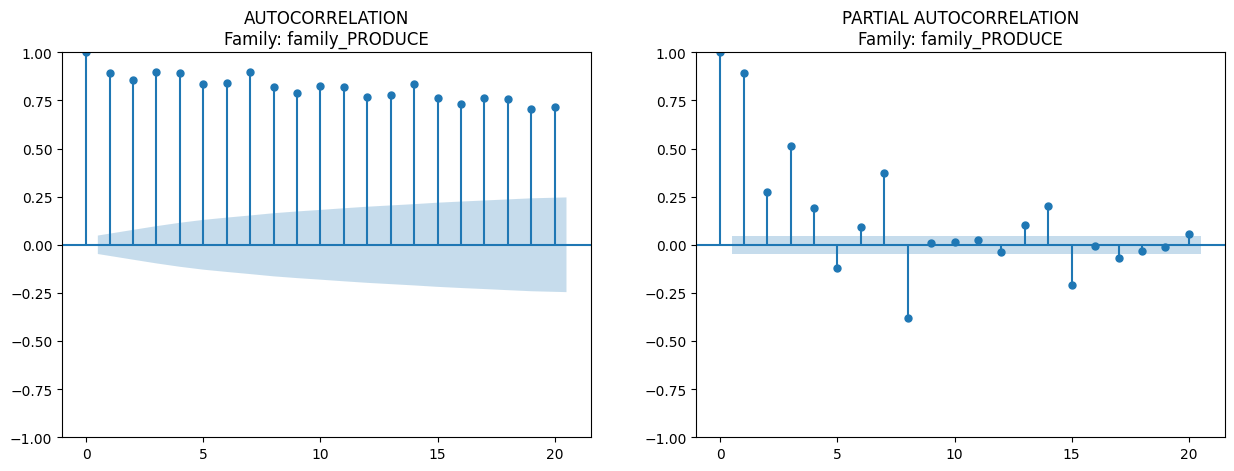

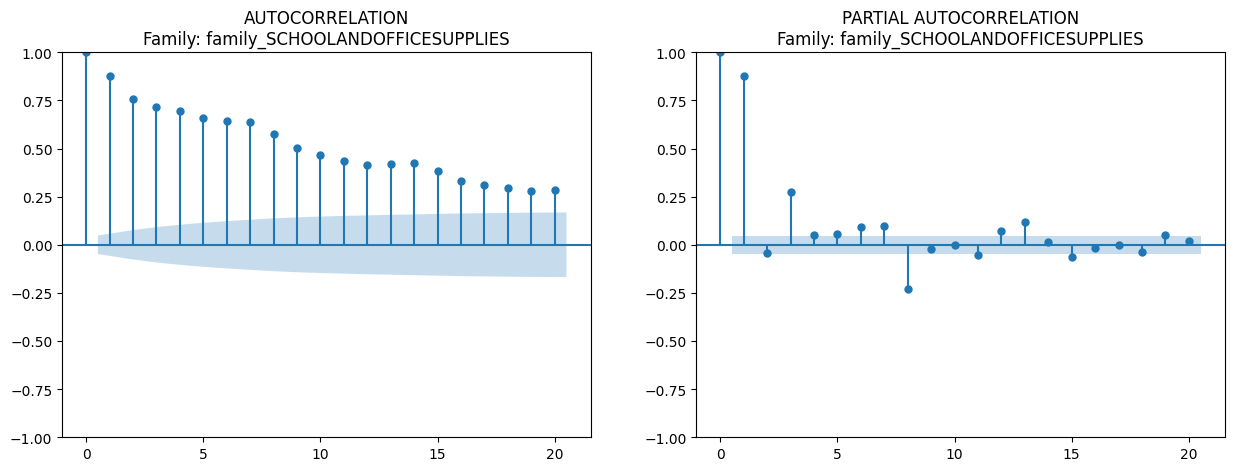

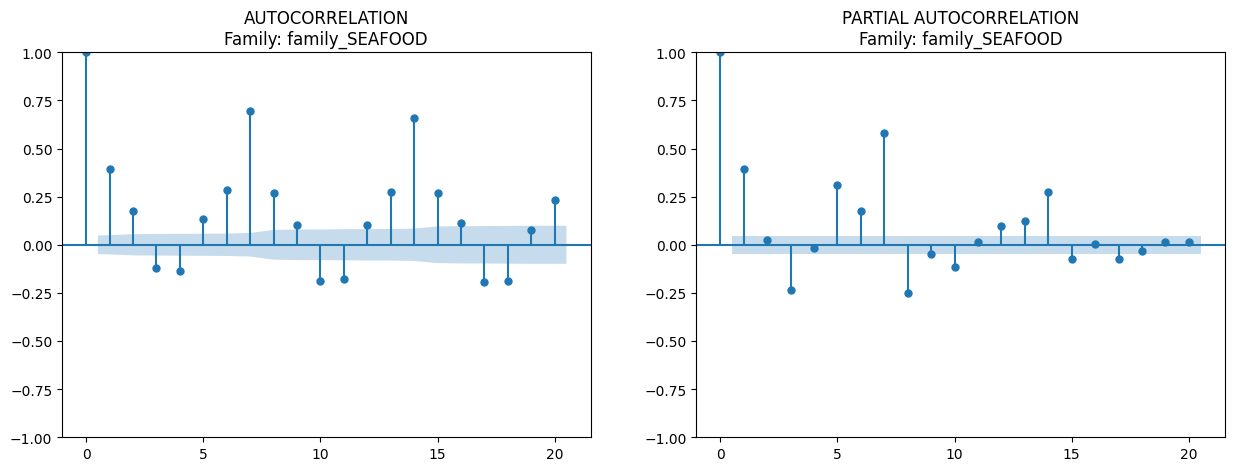

In [ ]:
#### 1. Group by date and family
family_cols = [col for col in pred.columns if col.startswith('family_')]
# Simplest Approach seems to be reverting one-hot family encodings back and
# using groupby
acf_train = train.copy()
acf_train['family'] = acf_train[family_cols].idxmax(axis=1)
acf_train = acf_train.groupby(["date", "family"]).agg(
    total_sales = ('sales', 'sum')
).reset_index()
#acf_train
# 2. Plot 33x2 charts (ACF & PACF for each family)
for family in acf_train['family'].unique():
    family_train = acf_train[acf_train['family'] == family]
    family_sales = family_train['total_sales']

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    #Pretty sure this gives daily info, so no need for resampling
    plot_acf(family_sales, lags=20, ax=ax[0], title=f"AUTOCORRELATION\nFamily: {family}")
    plot_pacf(family_sales, lags=20, ax=ax[1], title=f"PARTIAL AUTOCORRELATION\nFamily: {family}")


### Q12. ADF Test -> ARIMA

In [ ]:
# 1. Groupby date, sales and onpromotion
promotion = train.groupby(['date', 'onpromotion']).agg(
    total_sales=('sales', 'sum')
).reset_index()
# 2. Now get the sales time series
sales_time_series = promotion.groupby('date')['total_sales'].sum()
total_sales = promotion.groupby('date').agg(
    total_sales = ('total_sales', 'sum')
)
# 3. Find the autocorrelation of the time series you just store in step 2.
autocorr = sales_time_series.autocorr()
# Print autocorrelation
print("Autocorrelation:", autocorr)

Autocorrelation: 0.7604647648403222


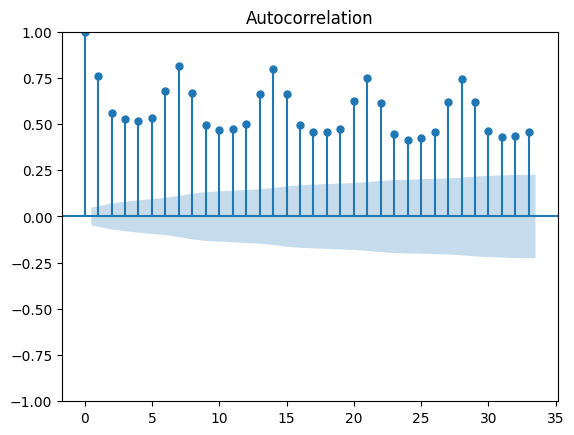

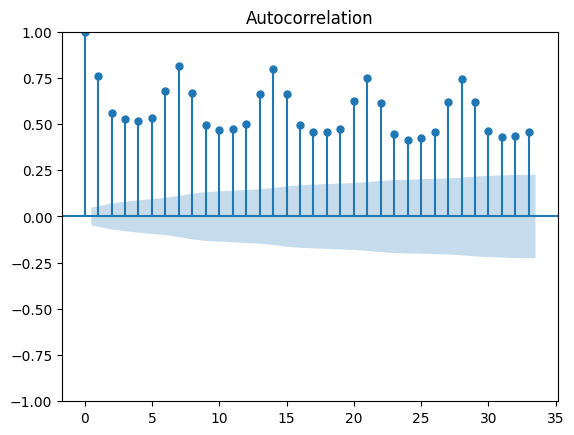

In [ ]:
# Plot ACF on sales time series
plot_acf(sales_time_series)

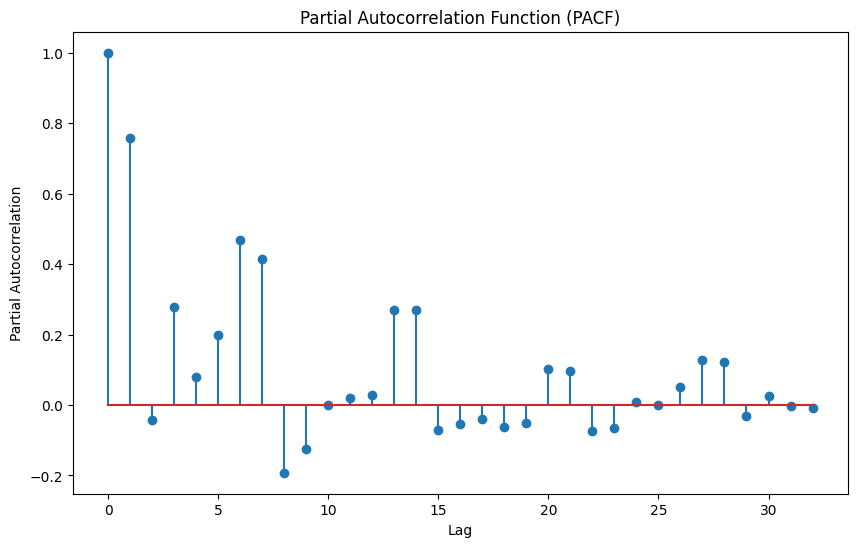

In [ ]:
# Plot the PACF
fig, ax = plt.subplots(figsize=(10, 6))

##########
# TODO: Your plot code goes here:
##########
autocorrelation = sm.tsa.pacf(total_sales['total_sales'])
plt.stem(range(len(autocorrelation)), autocorrelation)
##########
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')

plt.show()

#### Differencing technique
This process is meant to transform the time series data to stationary, as ARIMA model only works with stationary time series data.

In [ ]:
# 1. Compute and store the diff series
total_sales['diff_sales'] = total_sales['total_sales'].diff()
# 2. Drop NA or any other erroneous values.
total_sales = total_sales.dropna()

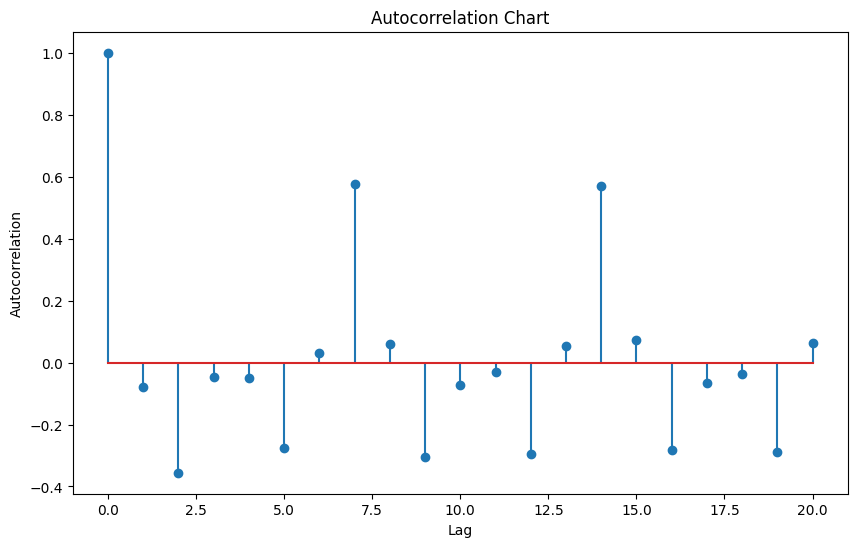

In [ ]:
# Compute the autocorrelation (nlags = 20)
# Plot the autocorrelation chart (use plt.stem)
plt.figure(figsize=(10, 6))

############
# TODO: Your code goes here:
############
autocorrelation = sm.tsa.acf(total_sales['diff_sales'], nlags=20)
plt.stem(range(len(autocorrelation)), autocorrelation)

############

plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Chart')
plt.show()

### Augmented Dickey-Fuller (ADF) test

The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine whether a time series is stationary or non-stationary. Stationarity is an important assumption in many time series analysis models.

The ADF test evaluates the null hypothesis that the time series has a unit root, indicating non-stationarity. The alternative hypothesis is that the time series is stationary.

When performing the ADF test, we obtain the ADF statistic and the p-value. The ADF statistic is a negative number and the more negative it is, the stronger the evidence against the null hypothesis. The p-value represents the probability of observing the ADF statistic or a more extreme value if the null hypothesis were true. A low p-value (below a chosen significance level, typically 0.05) indicates strong evidence against the null hypothesis and suggests that the time series is stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
# TODO - q12
# 1. Perform the ADF test
result = adfuller(total_sales['diff_sales'])
# 2. Extract the test statistics and p-value
adf_statistic = result[0]
p_value = result[1]
# 3. Print these values
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)

ADF Statistic: -11.553711182187332
p-value: 3.398751355603155e-21


The ADF statistic is (around) -11.4. This statistic is a negative value and is more negative than the critical values at common significance levels. This suggests strong evidence against the null hypothesis of a unit root, indicating that the time series is stationary.

The p-values (around)  i6.76e-2121, which is a very small value close to zero. Typically, if the p-value is below a chosen significance level (e.g., 0.05), it indicates strong evidence to reject the null hypothesis. In your case, the extremely small p-value suggests strong evidence against the presence of a unit root and supports the stationarity of the time series.

**TODO** Choose the right p, q and d values for your ARIMA model

In [ ]:
# TODO: Replace with appropriate p,d,q values for ARIMA
#plot_pacf(total_sales['diff_sales'])
p_arima = 6

d_arima = 1

#autocorrelation doesn't really decrease, so this is just picking the highest
q_arima = 8

In [ ]:
# 1. Get sales series as training data (np array with appropriate dtype)
train_data = total_sales['total_sales'].values.astype('float64')
# 2. Using statsmodel.tsa lib. Initialize an ARIMA model with the p,d,q params you defined.
model = sm.tsa.ARIMA(train_data, order=(p_arima, d_arima, q_arima))
# 3. Fit the model
result = model.fit()
# Errors indicate ARIMA maybe isn't a good fit?
# Would make sense given that ACF/PACF graphs don't seem to decrease

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
# Print the post model fitting summary
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1668
Model:                 ARIMA(6, 1, 8)   Log Likelihood              -21574.513
Date:                Thu, 05 Dec 2024   AIC                          43179.025
Time:                        02:55:22   BIC                          43260.307
Sample:                             0   HQIC                         43209.146
                               - 1668                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6289      0.061     10.251      0.000       0.509       0.749
ar.L2         -0.5142      0.062     -8.239      0.000      -0.636      -0.392
ar.L3         -0.0705      0.084     -0.837      0.4

In [ ]:
# Make predictions & submit to competition using your best model

#just use adfuller test with p < 0.05 to determine d
# Should only need forecasts
forecasts = {}
def find_arima_params(data):
    #0-2 should be good enough
    opt_d = 0
    for d in range(3):
        result = adfuller(data)
        p_value = result[1]
        if p_value < 0.05: #typical threshold
            opt_d = d
            break
        data = np.diff(data)
    return (1, opt_d, 1)


# Similar code to lin regression case except using ARIMA for prediction
family_columns = [col for col in train.columns if col.startswith('family_')]
stores = train['store_nbr'].unique()
for store in stores:
    print(store)
    # Filter for the specific store
    store_data = train[train['store_nbr'] == store].copy()

    for family_col in family_columns:
        # Filter for the specific family within the store
        family_store_data = store_data[store_data[family_col] == 1]
        # Specifically want sales data
        sales_data = family_store_data['sales'].values.astype('float64')

        #ADFuller Raises an error for constant data, so we just predict the value
        if np.all(sales_data == sales_data[0]):
            constant_forecast = [sales_data[0]] * 15
            forecasts[(store,family_col)] = constant_forecast
            continue

        best_params = find_arima_params(sales_data.copy())
        if best_params is not None:
            order = best_params
            model = sm.tsa.ARIMA(sales_data, order=order)
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=15).tolist()
            forecasts[(store, family_col)] = forecast

1.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
2.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
3.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
4.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
5.0
50.0
51.0
52.0
53.0
54.0
6.0
7.0
8.0
9.0


In [ ]:
#submit predictions
pred = test.copy()
#reset index fixes an indexing issue with test.copy()
pred.reset_index(drop=True, inplace=True)
pred['sales'] = 0.0
pred['family'] = pred[family_cols].idxmax(axis=1)
cols_to_keep = ['date', 'sales', 'family', 'store_nbr']
pred = pred[cols_to_keep]
#get the day of prediction
pred['day'] = pred['date'].dt.day
pred['forecast_index'] = pred['day'] - 1
#get the predictions
def get_forecast(row):
    family = row['family']  # Get the family
    store = row['store_nbr']  # Get the store number
    day_index = row['forecast_index']  # Get the day index

    # Look up the forecast in the dictionary
    forecast_key = (store, family)
    if forecast_key in forecasts:
        forecast_list = forecasts[forecast_key]
        # Return the corresponding forecasted value for the day
        if 0 <= day_index < len(forecast_list):
            return forecast_list[day_index]
    return 0.0  # Default to 0.0 if forecast is not available

pred['sales'] = pred.apply(get_forecast, axis=1)
#try to ensemble the 3 models
arima_pred = pred['sales']
print(pred['sales'])
make_submission(pred['sales'])
#RMSLE: 0.50575

0           4.325714
1           0.000000
2           2.957877
3        2068.300908
4           0.313301
            ...     
26725     484.310932
26726      88.446698
26727    1469.213048
26728      11.167484
26729      16.433917
Name: sales, Length: 26730, dtype: float64


## Section 3

### Q13 Define a validation set. What will be the most appropriate time period for this validation set?

In [ ]:
# Get the val set:

### Q14. LightGBM

In [ ]:
import lightgbm as lgb

In [ ]:
# Process your data to the appropriate dtypes, vars, etc.

In [ ]:
# Use the lgb.Dataset method to intialize your dataset iterables.

# 1. Make one for the train set:

# 2. Make another for the val set you defined in Q13:


In [ ]:
# Fill the dict with appropriate params:
#lgb_params = {'num_leaves': ,
#              'learning_rate': ,
#              'feature_fraction': ,
#              'max_depth': ,
#              'verbose': 20,
#              'num_boost_round': ,
#              'early_stopping_rounds': ,
#              'nthread': -1}

In [ ]:
# Complete the model initialization/train params)
#model = lgb.train(lgb_params, ...

In [ ]:
# 1. Predict the sales value on your val set using the best_iteration recorded by the LGBM
# 2. Compute and print the RMSLE on this val set.

In [ ]:
# 1. Pre-process your test set to appropriate format.
# 2. Predict -> Save using make_submission -> Submit to competition
# 3. Note your RMSLE for LGBM

### Q15. CatBoost

In [ ]:
from catboost import Pool, CatBoostRegressor

In [ ]:
# Fill out missing params for catboost appropriately here:
#catboost_params = {
#    'iterations': ,           # Number of boosting rounds
#    'learning_rate': ,        # Learning rate for gradient boosting
#    'depth': ,                   # Depth of each tree
#    'loss_function': 'RMSLE',      # Loss function (Root Mean Squared Error for regression)
#    'eval_metric': 'RMSLE',        # Evaluation metric
#    'random_seed': 42,            # Ensures reproducibility
#    'early_stopping_rounds': ,  # Stops training if no improvement after 50 rounds
#    'verbose': 100                # Prints training progress every 100 rounds
#}

In [ ]:
# 1. Define the model

# 2. Fit


In [ ]:
# 3. Preprocess your test data appropriately

# 4. Make Predictions

In [ ]:
# 5. Use make_submission -> Submit to competition

# 6. Note your RMSLE for this model

### Q16. XGBoost

In [ ]:
from xgboost import XGBRegressor

In [ ]:
# 1. Initialize model with random state = 42 to be consistent with CatBoost

# 2. Fit


In [ ]:
# 3. Make Predictions.

In [ ]:
# 4. make_submission -> Submit to competition

# 5. Note your RMSLE

### Q17. Optuna for automatic hyperparameter optimization

In [ ]:
import optuna
import time

In [ ]:
def objective_lgb(trial):
    # 1. Define the parameter search space

    # 2. Create datasets (train, val) for LightGBM

    # 3. Train the model

    # 4. Evaluate on the validation set

    # 5. Return the metric score

    pass

# Create Optuna study to minimize the objective function

start = time.time()
# 1. Create the optuna study and specify appropriate direction

# 2. Optimize (pay attention to recommended trials; 50 takes too long)

# 3. Get the best parameters

# 4. Print them.
# print("Best parameters:", best_params)

print("Took:", time.time() - start, "seconds")

In [ ]:
# Make a competition submission using these parameters
# Note these values.

In [ ]:
# Do the same for Catboost

In [ ]:
# Do the same for XGBoost

### Q18. Which out of the three Catboost vs LightGBM vs XGBoost provides the best score? Why do you think this model is more suited to this dataset/problem?

In [ ]:
print("<Your answer goes here>")

## Optional Extra Credit Section - Achieve the lowest score

### Cross Validation Strategies & Ensembling

In [ ]:
# 1. Try different Validation sets
# 2. Try ensembling different methods used in this assignment together
#Do ensemble
ensemble_predictions = (ema_pred + linear_pred + arima_pred)/3.0
print(ensemble_predictions)
make_submission(ensemble_predictions)

0           4.452829
1           0.000000
2           2.743415
3        2115.186522
4           0.235978
            ...     
26725     433.225874
26726      91.844440
26727    1800.043928
26728      34.402665
26729      15.581434
Name: sales, Length: 26730, dtype: float64
